# Natural Language Processing with Deep Learning

__This is exactly the same notebook as in `../week10_textconv/.`__

__Feel free submit the seminar notebook, just make sure you read the assignments at the end.__

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
146256,70731008,Recruitment Consultant,Are you an experienced recruitment professiona...,Bristol South West,Bristol,NaN,permanent,NaN,IT Jobs,27000,27000,technojobs.co.uk,10.203629
167456,71306189,PA to Sales Director,My client a market leader in its field is look...,Weybridge Surrey South East,Weybridge,NaN,permanent,Brook Street Bureau PLC,IT Jobs,28000 - 34000 per annum,31000,cwjobs.co.uk,10.341775
136549,70333307,Half Term Club Football Head Coach,"As a company, Onside Sports Coaching are a mul...","Chorley, Lancashire",Chorley,NaN,contract,Onside Soccer Coaching,Other/General Jobs,18 p/h,34560,uksport.gov.uk,10.450481


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" fields
all_words = []
data["Title"].apply(lambda x: all_words.extend(x.split()))
data["FullDescription"].apply(lambda x: all_words.extend(x.split()))
token_counts.update(all_words)

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5,0,'Counts')

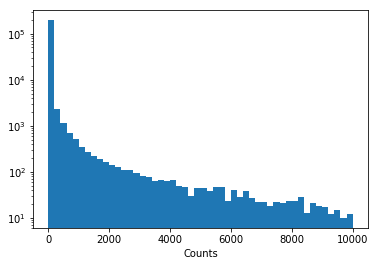

In [8]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [key for key in token_counts if token_counts[key] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [12]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [17]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [18]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[ 1336,    86, 13123,   282,  2375,  8830,  1314,    15,  7158,
          1464],
        [  142,   808,   325,    88,   971, 12556,   142,  6261,   575,
            57],
        [  558,  2133,   944,    73,   561,  3261,   971,   217,   142,
         15739]], dtype=int32),
 'Log1pSalary': array([10.959558, 10.71444 , 11.042922], dtype=float32),
 'Title': array([[ 673,   88,   11,   18,   36,   88],
        [ 808,  325,   88,    1,    1,    1],
        [1493,   94,   88, 2271,    1,    1]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [19]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [20]:
class Optional(nn.Module):
    def __init__(self, module, use_module):
        super().__init__()
        self.use_module = use_module
        if self.use_module:
            self.internal_module = module
        
    
    def forward(self, x):
        if self.use_module:
            return self.internal_module(x)
        return x

class ConvPoolBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, padding=0, stride=1,
                 use_bn=False, use_dropout=False, dropout_p=0.5, global_pool=True):
        super().__init__()
        self.internal_block = nn.Sequential(
            nn.Conv1d(in_size, out_size, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            Optional(nn.BatchNorm1d(out_size), use_bn),
            Optional(GlobalMaxPooling(), global_pool),
            Optional(nn.MaxPool1d(kernel_size=2), not global_pool),
            nn.ReLU(),
            Optional(nn.Dropout(p=dropout_p), use_dropout)) 
    
    def forward(self, x):
        return self.internal_block(x)

class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), in_size=64, out_size=64,
                 convolution_blocks=ConvPoolBlock(64, 64, kernel_size=3, padding=1)):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, in_size, padding_idx=PAD_IX)
        self.conv_blocks = convolution_blocks      
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv_blocks(h)
        h = self.dense(h)
        
        return h

In [21]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [22]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class JobDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), in_size=64, out_size=64,
                 convolution_blocks=ConvPoolBlock(64, 64, kernel_size=3, padding=1)):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, in_size, padding_idx=PAD_IX)
        self.conv_blocks = convolution_blocks     
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv_blocks(h)
        h = self.dense(h)
        
        return h

class ParallelCnnEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), in_size=64, out_size=64, use_dropout=False,
                 use_bn=True, dropout_p=0.5):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, in_size, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(in_size, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_size, out_size, kernel_size=3, padding=1)
        self.pool = GlobalMaxPooling()
        self.bn = Optional(nn.BatchNorm1d(out_size), use_bn)
        self.dropout = Optional(nn.Dropout(dropout_p), use_dropout)
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h2 = self.conv2(h)
        h = torch.cat((h1, h2), dim=2)
        h = self.bn(h)
        h = self.pool(h)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.dense(h)
        
        return h
    

class LSTMEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), in_size=64, out_size=64,
                 hidden_size=512, num_layers=3, use_dropout=False, use_bn=True,
                 dropout_p=0.5, bidirectional=True):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, in_size, padding_idx=PAD_IX)
        self.conv = nn.Conv1d(in_size, out_size, kernel_size=3, padding=1)
#         lstm_dropout = 0
#         if use_dropout:
#             lstm_dropout = dropout_p
        self.lstm = nn.LSTM(input_size=out_size, hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional)
        self.pool = GlobalMaxPooling()
        self.bn = Optional(nn.BatchNorm1d(out_size), use_bn)
        self.dropout = Optional(nn.Dropout(dropout_p), use_dropout)
        if bidirectional:
            self.dense = nn.Linear(hidden_size * 2, out_size)
        else:
            self.dense = nn.Linear(hidden_size, out_size)
    
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv(h)
        h = self.bn(h)
        h = F.relu(h)
        h = self.dropout(h)
        h = torch.transpose(h, 1, 2)
        self.lstm.flatten_parameters()
        h, _ = self.lstm(h)
        h = F.relu(h)
        h = torch.transpose(h, 1, 2)
        h = self.pool(h)
        h = self.dense(h)
        return h

In [23]:
desc_encoder = JobDescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [24]:
class ShapePrinter(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as well as some layers for head and categorical branch.
    """
    
    def __init__(self,title_encoder, desc_encoder,
                 out_size=64,
                 n_cat_features=len(categorical_vectorizer.vocabulary_),
                 use_bn=False,
                 use_dropout=False,
                 dropout_p=0.5):
        super().__init__()
        
        self.title_encoder = title_encoder
        self.desc_encoder = desc_encoder
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_feats_encoder = nn.Sequential(nn.Linear(n_cat_features, 512),
                                               Optional(nn.BatchNorm1d(512), use_bn),
                                               nn.ReLU(),
                                               Optional(nn.Dropout(dropout_p), use_dropout),
                                               nn.Linear(512, 256),
                                               Optional(nn.BatchNorm1d(256), use_bn),
                                               nn.ReLU(),
                                               Optional(nn.Dropout(dropout_p), use_dropout),
                                               nn.Linear(256, out_size))
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.final_layers = nn.Sequential(nn.Linear(out_size * 3, 128),
                                          Optional(nn.BatchNorm1d(128), use_bn),
                                          nn.ReLU(),
                                          Optional(nn.Dropout(dropout_p), use_dropout),
                                          nn.Linear(128, 64),
                                          Optional(nn.BatchNorm1d(64), use_bn),
                                          nn.ReLU(),
                                          Optional(nn.Dropout(dropout_p), use_dropout),
                                          nn.Linear(64, 32),
                                          Optional(nn.BatchNorm1d(32), use_bn),
                                          nn.ReLU(),
                                          Optional(nn.Dropout(dropout_p), use_dropout),
                                          nn.Linear(32, 16),
                                          Optional(nn.BatchNorm1d(16), use_bn),
                                          nn.ReLU(),
                                          Optional(nn.Dropout(dropout_p), use_dropout),
                                          nn.Linear(16, 1))
        
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
            
        # apply categorical encoder
        cat_h = self.cat_feats_encoder(cat_features)        
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.final_layers(joint_h)
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:, 0]

In [25]:
title_encoder = TitleEncoder()
desc_encoder = JobDescriptionEncoder()
model = FullNetwork(title_encoder, desc_encoder).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).cuda()
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).cuda()
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).cuda()
reference = Variable(torch.FloatTensor(batch[target_column])).cuda()

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [27]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [28]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [37]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        if start + batch_size < len(indices):
            yield generate_batch(data.iloc[indices[start : start + batch_size]],
                                 replace=False, max_len=max_len)

In [30]:
from copy import deepcopy
def train(model, data_train, data_val, num_epochs,
          batch_size, batches_per_epoch, optimizer, use_cuda=True,
          early_stopping_iters=100): 
    if use_cuda:
        model = model.cuda()
    train_losses = []
    train_mae_list = []
    val_losses = []
    val_mae_list = []
    best_on_val_state_dict = None
    num_iters_since_best = 0
    best_avg_val_loss = None
    for epoch_i in range(num_epochs):
        print("Training:")
        train_loss = train_mae = train_batches = 0    
        model.train(True)

        for batch in iterate_minibatches(data_train, batch_size=batch_size,
                                         max_batches=batches_per_epoch):

            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))
            if use_cuda:
                title_ix = title_ix.cuda()
                desc_ix = desc_ix.cuda()
                cat_features = cat_features.cuda()
                reference = reference.cuda()
            
            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            current_train_loss = loss.data.cpu().numpy()[0]
            train_loss += current_train_loss
            current_train_mae = compute_mae(reference, prediction).data.cpu().numpy()[0]
            train_mae += current_train_mae
            train_batches += 1
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        avg_train_mae = train_mae / train_batches
        train_mae_list.append(avg_train_mae)
        print("\tLoss:\t%.5f" % (avg_train_loss))
        print("\tMAE:\t%.5f" % (avg_train_mae))
        print('\n\n')

        print("Validation:")
        val_loss = val_mae = val_batches = 0
        model.train(False)
        avg_val_loss = 0
        for batch in iterate_minibatches(data_val, batch_size=batch_size, 
                                         shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
            reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)
            if use_cuda:
                title_ix = title_ix.cuda()
                desc_ix = desc_ix.cuda()
                cat_features = cat_features.cuda()
                reference = reference.cuda()
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)
            current_val_loss = loss.data.cpu().numpy()[0]
            val_loss += current_val_loss
            current_val_mae = compute_mae(reference, prediction).data.cpu().numpy()[0]
            val_mae += current_val_mae
            val_batches += 1
        avg_val_loss = val_loss / val_batches 
        avg_val_mae = val_mae / val_batches
        val_losses.append(avg_val_loss)
        val_mae_list.append(avg_val_mae)
        if best_avg_val_loss is None or avg_val_loss < best_avg_val_loss:
            best_avg_val_loss = avg_val_loss
            best_on_val_state_dict = deepcopy(model.state_dict())
            num_iters_since_best = 0
        print("\tLoss:\t%.5f" % (avg_val_loss))
        print("\tMAE:\t%.5f" % (avg_val_mae))
        print(num_iters_since_best)
        print('\n\n')
        if num_iters_since_best > early_stopping_iters:
            break
        num_iters_since_best += 1
    return train_losses, val_losses, train_mae_list, val_mae_list, best_on_val_state_dict

In [31]:
def evaluate(model, data_val, batch_size, use_cuda=True):
    print("Final eval:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    for batch in iterate_minibatches(data_val, batch_size, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True)
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True)
        if use_cuda:
            title_ix = title_ix.cuda()
            desc_ix = desc_ix.cuda()
            cat_features = cat_features.cuda()
            reference = reference.cuda()
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.cpu().numpy()[0]
        val_mae += compute_mae(reference, prediction).data.cpu().numpy()[0]
        val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

In [32]:
from IPython import display
def plot_metrics(all_metrics, subplots_layout=(1, 2), 
                 figsize=(20, 10), log_scale=False):
    display.clear_output(wait=True)
    fig, axes = plt.subplots(*subplots_layout, figsize=figsize)
    fig.subplots_adjust(hspace=100)
    if log_scale:
        plt.yscale('log')
    width = axes.shape[0]
    height = 1
    if len(axes.shape) > 1:
        height = axes.shape[1]
    for idx, title in enumerate(all_metrics):
        i = idx // width
        j = idx % width
        for label in all_metrics[title]:
            metric_values = all_metrics[title][label]
            if len(axes.shape) > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
            ax.set(title=title, ylabel=title.lower(), xlabel="#iteration")
            ax.plot(metric_values, label=label)
            ax.legend()
    plt.show()

# Experiments

## Baseline

In [38]:
title_encoder = TitleEncoder()
desc_encoder = JobDescriptionEncoder()
model = FullNetwork(title_encoder, desc_encoder)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
batch_size = 32
batches_per_epoch = 100
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val, num_epochs,
                                                        batch_size, batches_per_epoch,
                                                        opt, use_cuda=True)

Training:


	Loss:	16.73896
	MAE:	66834.52064



Validation:




	Loss:	0.66439
	MAE:	8611.16048
0



Training:



	Loss:	0.55218
	MAE:	6931.57191



Validation:



	Loss:	0.40544
	MAE:	5602.57038
0



Training:



	Loss:	0.35856
	MAE:	5692.94866



Validation:



	Loss:	0.32787
	MAE:	5644.16436
0



Training:



	Loss:	0.30408
	MAE:	5010.30227



Validation:



	Loss:	0.29900
	MAE:	4691.90249
0



Training:



	Loss:	0.31309
	MAE:	5197.59746



Validation:



	Loss:	0.26609
	MAE:	4516.63101
0



Training:



	Loss:	0.27598
	MAE:	4868.71222



Validation:



	Loss:	0.26731
	MAE:	5424.03208
1



Training:



	Loss:	0.25152
	MAE:	4660.53390



Validation:



	Loss:	0.21882
	MAE:	4468.38751
0



Training:



	Loss:	0.23782
	MAE:	4552.52377



Validation:



	Loss:	0.23979
	MAE:	5107.92237
1



Training:



	Loss:	0.21914
	MAE:	4453.08388



Validation:



	Loss:	0.20416
	MAE:	3994.82382
0



Training:



	Loss:	0.19095
	MAE:	4101.59399



Validation:



	Loss:	0.21459
	MAE:	4007.51640
1



Training:



	Loss:	0.17716
	MAE:	3996.73451



Validation:



	Loss:	0.18609
	MAE:	4197.84424
0



Training:



	Loss:	0.19473
	MAE:	4073.99836



Validation:



	Loss:	0.17142
	MAE:	3937.45573
0



Training:



	Loss:	0.19702
	MAE:	4084.99931



Validation:



	Loss:	0.16545
	MAE:	3913.68503
0



Training:



	Loss:	0.17749
	MAE:	4084.13627



Validation:



	Loss:	0.15925
	MAE:	3808.50841
0



Training:



	Loss:	0.17663
	MAE:	3981.65600



Validation:



	Loss:	0.16085
	MAE:	3907.22668
1



Training:



	Loss:	0.18222
	MAE:	4049.45206



Validation:



	Loss:	0.22935
	MAE:	5386.48541
2



Training:



	Loss:	0.14852
	MAE:	3697.06272



Validation:



	Loss:	0.17978
	MAE:	4424.58093
3



Training:



	Loss:	0.14283
	MAE:	3587.03629



Validation:



	Loss:	0.14247
	MAE:	3687.08540
0



Training:



	Loss:	0.15729
	MAE:	3823.82400



Validation:



	Loss:	0.13556
	MAE:	3523.60515
0



Training:



	Loss:	0.15397
	MAE:	3865.99165



Validation:



	Loss:	0.13646
	MAE:	3354.93246
1



Training:



	Loss:	0.14172
	MAE:	3582.04138



Validation:



	Loss:	0.16025
	MAE:	4158.47152
2



Training:



	Loss:	0.13399
	MAE:	3461.97674



Validation:



	Loss:	0.13137
	MAE:	3297.33633
0



Training:



	Loss:	0.14632
	MAE:	3604.22565



Validation:



	Loss:	0.14023
	MAE:	3776.51982
1



Training:



	Loss:	0.13276
	MAE:	3577.82703



Validation:



	Loss:	0.12333
	MAE:	3359.71611
0



Training:



	Loss:	0.14151
	MAE:	3611.77679



Validation:



	Loss:	0.19277
	MAE:	3921.35039
1



Training:



	Loss:	0.16407
	MAE:	3846.36484



Validation:



	Loss:	0.14580
	MAE:	3878.98151
2



Training:



	Loss:	0.14162
	MAE:	3530.02416



Validation:



	Loss:	0.16831
	MAE:	4461.16900
3



Training:



	Loss:	0.14488
	MAE:	3588.17665



Validation:



	Loss:	0.13483
	MAE:	3692.11423
4



Training:



	Loss:	0.14558
	MAE:	3662.95567



Validation:



	Loss:	0.14695
	MAE:	3478.32236
5



Training:



	Loss:	0.12186
	MAE:	3377.17786



Validation:



	Loss:	0.11494
	MAE:	3284.32588
0



Training:



	Loss:	0.11424
	MAE:	3205.67666



Validation:



	Loss:	0.10924
	MAE:	3117.27595
0



Training:



	Loss:	0.11846
	MAE:	3237.80791



Validation:



	Loss:	0.10925
	MAE:	3130.34418
1



Training:



	Loss:	0.13395
	MAE:	3521.46221



Validation:



	Loss:	0.12189
	MAE:	3486.73650
2



Training:



	Loss:	0.11202
	MAE:	3101.28253



Validation:



	Loss:	0.11043
	MAE:	3237.46470
3



Training:



	Loss:	0.11502
	MAE:	3247.11180



Validation:



	Loss:	0.10701
	MAE:	3017.60857
0



Training:



	Loss:	0.12323
	MAE:	3336.92973



Validation:



	Loss:	0.10520
	MAE:	3001.54371
0



Training:



	Loss:	0.13001
	MAE:	3525.40065



Validation:



	Loss:	0.10684
	MAE:	3020.82057
1



Training:



	Loss:	0.10798
	MAE:	3076.77089



Validation:



	Loss:	0.10255
	MAE:	3042.32389
0



Training:



	Loss:	0.13339
	MAE:	3497.59831



Validation:



	Loss:	0.10110
	MAE:	2998.01130
0



Training:



	Loss:	0.11054
	MAE:	3206.73366



Validation:



	Loss:	0.12957
	MAE:	3282.74668
1



Training:



	Loss:	0.12375
	MAE:	3394.83772



Validation:



	Loss:	0.10112
	MAE:	2941.55298
2



Training:



	Loss:	0.12401
	MAE:	3426.26964



Validation:



	Loss:	0.10476
	MAE:	2989.19705
3



Training:



	Loss:	0.13147
	MAE:	3520.39086



Validation:



	Loss:	0.09985
	MAE:	2925.07094
0



Training:



	Loss:	0.13714
	MAE:	3590.54720



Validation:



	Loss:	0.10322
	MAE:	2965.13857
1



Training:



	Loss:	0.10706
	MAE:	3210.82228



Validation:



	Loss:	0.09514
	MAE:	2896.80421
0



Training:



	Loss:	0.11354
	MAE:	3263.73580



Validation:



	Loss:	0.09447
	MAE:	2877.31828
0



Training:



	Loss:	0.11992
	MAE:	3400.50946



Validation:



	Loss:	0.09580
	MAE:	2870.43670
1



Training:



	Loss:	0.10988
	MAE:	3099.40003



Validation:



	Loss:	0.09739
	MAE:	2889.23565
2



Training:



	Loss:	0.11009
	MAE:	3158.85090



Validation:



	Loss:	0.10934
	MAE:	3048.69001
3



Training:



	Loss:	0.13164
	MAE:	3509.41937



Validation:



	Loss:	0.12430
	MAE:	3654.38988
4



Training:



	Loss:	0.10678
	MAE:	3153.31079



Validation:



	Loss:	0.09702
	MAE:	2882.02960
5



Training:



	Loss:	0.11664
	MAE:	3303.16685



Validation:



	Loss:	0.09409
	MAE:	2908.40593
0



Training:



	Loss:	0.09669
	MAE:	2939.64178



Validation:



	Loss:	0.11778
	MAE:	3166.76078
1



Training:



	Loss:	0.10248
	MAE:	3033.57335



Validation:



	Loss:	0.12618
	MAE:	3725.17183
2



Training:



	Loss:	0.11619
	MAE:	3378.51138



Validation:



	Loss:	0.12515
	MAE:	3661.59682
3



Training:



	Loss:	0.11365
	MAE:	3227.33410



Validation:



	Loss:	0.09160
	MAE:	2882.92182
0



Training:



	Loss:	0.10275
	MAE:	3122.96967



Validation:



	Loss:	0.09198
	MAE:	2815.28922
1



Training:



	Loss:	0.11332
	MAE:	3231.46189



Validation:



	Loss:	0.20320
	MAE:	4141.43852
2



Training:



	Loss:	0.11100
	MAE:	3144.33302



Validation:



	Loss:	0.09297
	MAE:	2839.03261
3



Training:



	Loss:	0.10629
	MAE:	3056.41478



Validation:



	Loss:	0.11599
	MAE:	3549.12155
4



Training:



	Loss:	0.10005
	MAE:	3075.66703



Validation:



	Loss:	0.09599
	MAE:	3063.67473
5



Training:



	Loss:	0.10512
	MAE:	3153.64905



Validation:



	Loss:	0.08727
	MAE:	2805.29387
0



Training:



	Loss:	0.10303
	MAE:	3168.86195



Validation:



	Loss:	0.08936
	MAE:	2768.70355
1



Training:



	Loss:	0.09288
	MAE:	2892.79755



Validation:



	Loss:	0.12563
	MAE:	3757.19742
2



Training:



	Loss:	0.09977
	MAE:	3045.07501



Validation:



	Loss:	0.09449
	MAE:	3020.95553
3



Training:



	Loss:	0.09309
	MAE:	2964.68974



Validation:



	Loss:	0.08614
	MAE:	2775.73340
0



Training:



	Loss:	0.08778
	MAE:	2947.78499



Validation:



	Loss:	0.10906
	MAE:	3071.82934
1



Training:



	Loss:	0.09227
	MAE:	2961.74944



Validation:



	Loss:	0.08423
	MAE:	2732.97577
0



Training:



	Loss:	0.09239
	MAE:	2959.37170



Validation:



	Loss:	0.09158
	MAE:	2964.93994
1



Training:



	Loss:	0.09058
	MAE:	2988.00893



Validation:



	Loss:	0.11370
	MAE:	3499.05045
2



Training:



	Loss:	0.09233
	MAE:	2929.07572



Validation:



	Loss:	0.10383
	MAE:	2994.40961
3



Training:



	Loss:	0.08725
	MAE:	2826.69902



Validation:



	Loss:	0.09317
	MAE:	2829.16230
4



Training:



	Loss:	0.09050
	MAE:	2944.46188



Validation:



	Loss:	0.08558
	MAE:	2824.91730
5



Training:



	Loss:	0.09396
	MAE:	2897.36094



Validation:



	Loss:	0.09553
	MAE:	2855.30229
6



Training:



	Loss:	0.10214
	MAE:	3099.14258



Validation:



	Loss:	0.08365
	MAE:	2769.13879
0



Training:



	Loss:	0.08641
	MAE:	2791.21018



Validation:



	Loss:	0.08929
	MAE:	2946.25589
1



Training:



	Loss:	0.08134
	MAE:	2766.44974



Validation:



	Loss:	0.08094
	MAE:	2705.13202
0



Training:



	Loss:	0.09123
	MAE:	2888.39526



Validation:



	Loss:	0.08896
	MAE:	2924.49947
1



Training:



	Loss:	0.09154
	MAE:	2848.01875



Validation:



	Loss:	0.08699
	MAE:	2752.06327
2



Training:



	Loss:	0.07878
	MAE:	2692.70607



Validation:



	Loss:	0.08764
	MAE:	2875.76437
3



Training:



	Loss:	0.07956
	MAE:	2668.05848



Validation:



	Loss:	0.17668
	MAE:	3944.29803
4



Training:



	Loss:	0.10381
	MAE:	3130.17188



Validation:



	Loss:	0.12775
	MAE:	3878.43795
5



Training:



	Loss:	0.08320
	MAE:	2818.60778



Validation:



	Loss:	0.08586
	MAE:	2735.80851
6



Training:



	Loss:	0.08614
	MAE:	2834.66792



Validation:



	Loss:	0.08699
	MAE:	2886.67188
7



Training:



	Loss:	0.09488
	MAE:	2952.45006



Validation:



	Loss:	0.07956
	MAE:	2666.10209
0



Training:



	Loss:	0.09740
	MAE:	2974.98398



Validation:



	Loss:	0.08593
	MAE:	2749.66554
1



Training:



	Loss:	0.11150
	MAE:	3257.41390



Validation:



	Loss:	0.09569
	MAE:	3087.57721
2



Training:



	Loss:	0.09408
	MAE:	2991.40782



Validation:



	Loss:	0.17357
	MAE:	3839.67238
3



Training:



	Loss:	0.09046
	MAE:	2854.27972



Validation:



	Loss:	0.09583
	MAE:	3081.97559
4



Training:



	Loss:	0.08668
	MAE:	2897.12491



Validation:



	Loss:	0.09677
	MAE:	2907.51201
5



Training:



	Loss:	0.08675
	MAE:	2821.69942



Validation:



	Loss:	0.08006
	MAE:	2645.15678
6



Training:



	Loss:	0.09398
	MAE:	2949.86817



Validation:



	Loss:	0.08684
	MAE:	2930.61476
7



Training:



	Loss:	0.07684
	MAE:	2683.64936



Validation:



	Loss:	0.10433
	MAE:	3009.95782
8



Training:



	Loss:	0.07770
	MAE:	2769.04997



Validation:



	Loss:	0.07685
	MAE:	2609.82208
0



Training:



	Loss:	0.08279
	MAE:	2749.55982



Validation:



	Loss:	0.08423
	MAE:	2843.33697
1



Training:



	Loss:	0.08352
	MAE:	2857.73608



Validation:



	Loss:	0.09558
	MAE:	3144.35100
2



Training:



	Loss:	0.07812
	MAE:	2652.32528



Validation:



	Loss:	0.10499
	MAE:	3377.77950
3



Training:



	Loss:	0.08710
	MAE:	2833.53051



Validation:



	Loss:	0.08383
	MAE:	2688.04558
4



Training:



	Loss:	0.08175
	MAE:	2846.25768



Validation:



	Loss:	0.07777
	MAE:	2610.02198
5



Training:



	Loss:	0.10058
	MAE:	3101.00652



Validation:



	Loss:	0.07967
	MAE:	2637.77660
6





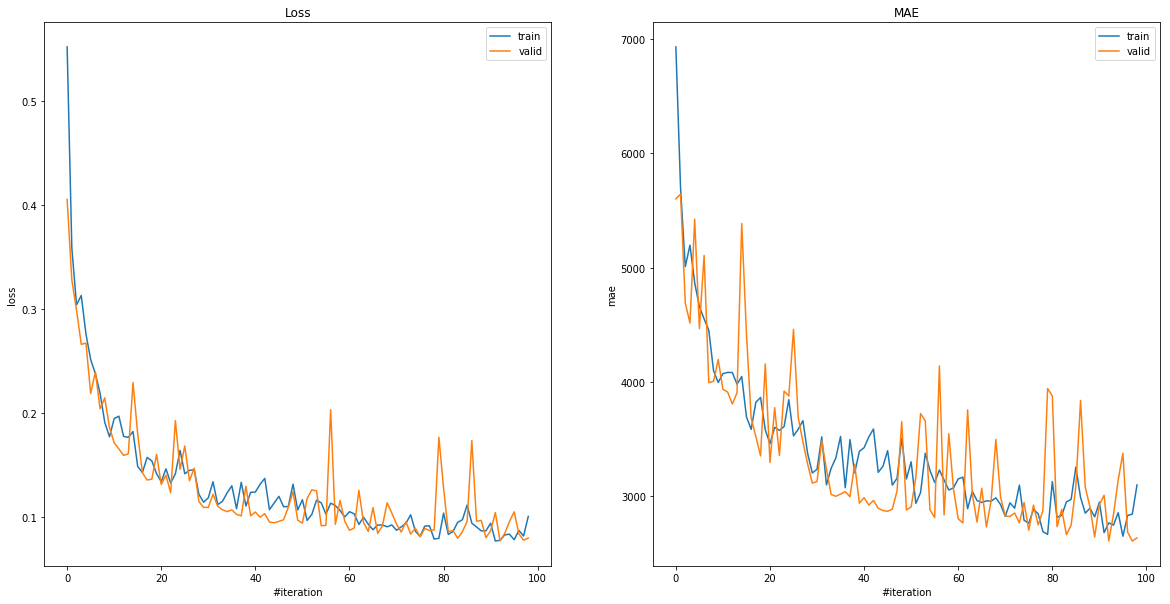

Final eval:



	Loss:	0.07685
	MAE:	2609.82208





In [41]:
plot_metrics({"Loss": {"train": train_losses[1:],
                       "valid": val_losses[1:]},
              "MAE": {"train": train_mae_list[1:],
                      "valid": val_mae_list[1:]}})
title_encoder = TitleEncoder()
desc_encoder = JobDescriptionEncoder()
model = FullNetwork(title_encoder, desc_encoder).cuda()
model.load_state_dict(best_model_dict)
evaluate(model, data_val, batch_size=batch_size, use_cuda=True)

## Baseline model + early stopping

In [44]:
title_encoder = TitleEncoder()
desc_encoder = JobDescriptionEncoder()
model = FullNetwork(title_encoder, desc_encoder)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000
batch_size = 32
batches_per_epoch = None
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val, num_epochs,
                                                        batch_size, batches_per_epoch,
                                                        opt, use_cuda=True,
                                                        early_stopping_iters=15)

Training:



	Loss:	0.32612
	MAE:	4566.75519



Validation:



	Loss:	0.18250
	MAE:	4023.01100
0



Training:



	Loss:	0.08305
	MAE:	2765.01444



Validation:



	Loss:	0.07615
	MAE:	2696.53851
0



Training:



	Loss:	0.06398
	MAE:	2420.76720



Validation:



	Loss:	0.12240
	MAE:	3344.31933
1



Training:



	Loss:	0.05233
	MAE:	2184.52704



Validation:



	Loss:	0.07376
	MAE:	2527.68624
0



Training:



	Loss:	0.04395
	MAE:	1996.70724



Validation:



	Loss:	0.05696
	MAE:	2190.76442
0



Training:



	Loss:	0.03793
	MAE:	1856.18031



Validation:



	Loss:	0.12727
	MAE:	4129.01908
1



Training:



	Loss:	0.03266
	MAE:	1728.33727



Validation:



	Loss:	0.05583
	MAE:	2182.61865
0



Training:



	Loss:	0.02830
	MAE:	1604.18636



Validation:



	Loss:	0.10017
	MAE:	2999.87183
1



Training:



	Loss:	0.02510
	MAE:	1509.01655



Validation:



	Loss:	0.05621
	MAE:	2151.63178
2



Training:



	Loss:	0.02259
	MAE:	1435.30051



Validation:



	Loss:	0.06988
	MAE:	2427.04222
3



Training:



	Loss:	0.02010
	MAE:	1354.71955



Validation:



	Loss:	0.06613
	MAE:	2342.88811
4



Training:



	Loss:	0.01789
	MAE:	1276.57256



Validation:



	Loss:	0.05483
	MAE:	2124.32384
0



Training:



	Loss:	0.01640
	MAE:	1223.96198



Validation:



	Loss:	0.06938
	MAE:	2616.27939
1



Training:



	Loss:	0.01520
	MAE:	1181.25159



Validation:



	Loss:	0.05643
	MAE:	2129.16246
2



Training:



	Loss:	0.01392
	MAE:	1130.49091



Validation:



	Loss:	0.05525
	MAE:	2102.90343
3



Training:



	Loss:	0.01298
	MAE:	1094.62881



Validation:



	Loss:	0.06664
	MAE:	2560.77373
4



Training:



	Loss:	0.01206
	MAE:	1056.36819



Validation:



	Loss:	0.07603
	MAE:	2838.27279
5



Training:



	Loss:	0.01119
	MAE:	1014.69594



Validation:



	Loss:	0.06602
	MAE:	2315.65806
6



Training:



	Loss:	0.01052
	MAE:	984.83520



Validation:



	Loss:	0.05620
	MAE:	2128.43037
7



Training:



	Loss:	0.00974
	MAE:	947.46478



Validation:



	Loss:	0.05817
	MAE:	2228.00272
8



Training:



	Loss:	0.00946
	MAE:	936.01777



Validation:



	Loss:	0.05645
	MAE:	2110.40391
9



Training:



	Loss:	0.00899
	MAE:	912.76078



Validation:



	Loss:	0.05880
	MAE:	2240.18081
10



Training:



	Loss:	0.00858
	MAE:	888.83158



Validation:



	Loss:	0.05635
	MAE:	2140.82301
11



Training:



	Loss:	0.00801
	MAE:	861.31176



Validation:



	Loss:	0.05625
	MAE:	2095.08424
12



Training:



	Loss:	0.00777
	MAE:	845.47223



Validation:



	Loss:	0.06012
	MAE:	2287.84537
13



Training:



	Loss:	0.00749
	MAE:	831.38778



Validation:



	Loss:	0.05680
	MAE:	2100.61409
14



Training:



	Loss:	0.00723
	MAE:	817.13921



Validation:



	Loss:	0.06404
	MAE:	2257.95798
15



Training:



	Loss:	0.00694
	MAE:	800.79989



Validation:



	Loss:	0.05620
	MAE:	2109.25667
16





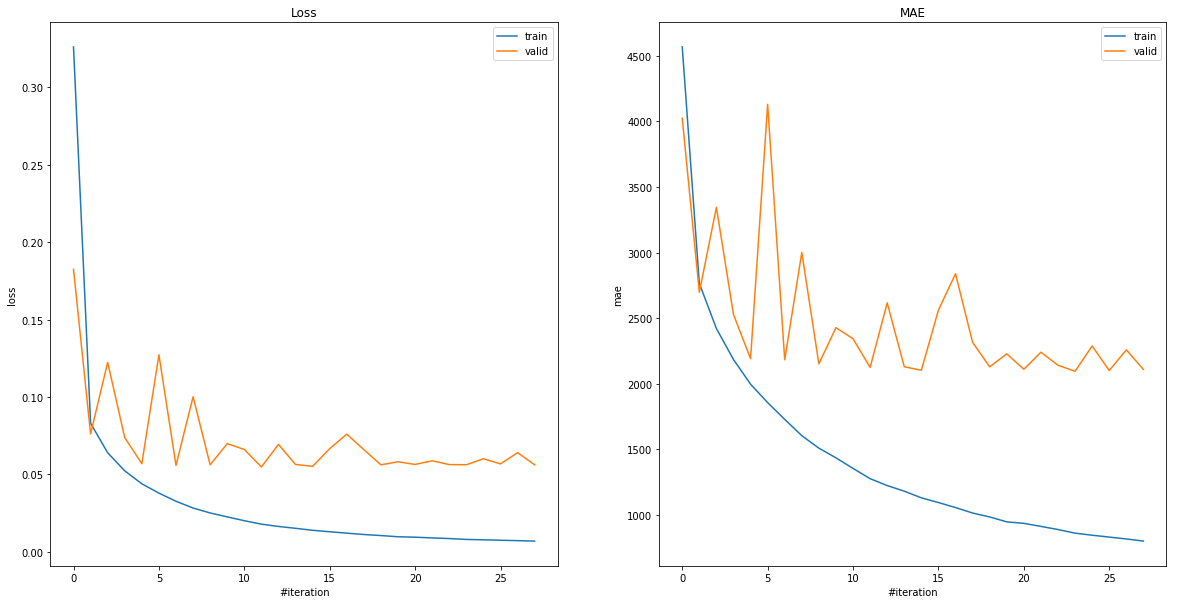

Final eval:



	Loss:	0.05483
	MAE:	2124.32384





In [45]:
plot_metrics({"Loss": {"train": train_losses,
                       "valid": val_losses},
              "MAE": {"train": train_mae_list,
                      "valid": val_mae_list}})
title_encoder = TitleEncoder()
desc_encoder = JobDescriptionEncoder()
model = FullNetwork(title_encoder, desc_encoder).cuda()
model.load_state_dict(best_model_dict)
evaluate(model, data_val, use_cuda=True)

## Baseline + BatchNorm + early stopping

In [46]:
title_encoder = TitleEncoder(convolution_blocks=ConvPoolBlock(64, 64, 
                                                              kernel_size=3,
                                                              padding=1, use_bn=True))

desc_encoder = JobDescriptionEncoder(convolution_blocks=ConvPoolBlock(64, 64, 
                                                                      kernel_size=3,
                                                                      padding=1, use_bn=True))
model = FullNetwork(title_encoder, desc_encoder, use_bn=True)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000
batch_size = 32
batches_per_epoch = None
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val, num_epochs,
                                                        batch_size, batches_per_epoch,
                                                        opt, use_cuda=True,
                                                        early_stopping_iters=15)

Training:



	Loss:	4.35362
	MAE:	4091.31918



Validation:



	Loss:	0.11487
	MAE:	3263.23338
0



Training:



	Loss:	0.07979
	MAE:	2703.96766



Validation:



	Loss:	0.11806
	MAE:	3319.19322
1



Training:



	Loss:	0.06567
	MAE:	2457.14468



Validation:



	Loss:	0.11163
	MAE:	3225.77314
0



Training:



	Loss:	0.05652
	MAE:	2278.42280



Validation:



	Loss:	0.09532
	MAE:	2898.01867
0



Training:



	Loss:	0.04935
	MAE:	2127.40125



Validation:



	Loss:	0.07575
	MAE:	2722.76618
0



Training:



	Loss:	0.04322
	MAE:	1987.45518



Validation:



	Loss:	0.07698
	MAE:	2640.26673
1



Training:



	Loss:	0.03780
	MAE:	1856.05947



Validation:



	Loss:	0.06739
	MAE:	2514.16894
0



Training:



	Loss:	0.03348
	MAE:	1750.09339



Validation:



	Loss:	0.08003
	MAE:	2776.83113
1



Training:



	Loss:	0.02975
	MAE:	1649.45971



Validation:



	Loss:	0.07476
	MAE:	2653.48290
2



Training:



	Loss:	0.02693
	MAE:	1564.93225



Validation:



	Loss:	0.05724
	MAE:	2252.72504
0



Training:



	Loss:	0.02449
	MAE:	1499.59995



Validation:



	Loss:	0.06615
	MAE:	2492.20237
1



Training:



	Loss:	0.02239
	MAE:	1438.74015



Validation:



	Loss:	0.05977
	MAE:	2362.82147
2



Training:



	Loss:	0.02046
	MAE:	1375.00224



Validation:



	Loss:	0.06134
	MAE:	2357.54854
3



Training:



	Loss:	0.01892
	MAE:	1324.92132



Validation:



	Loss:	0.05668
	MAE:	2266.67096
0



Training:



	Loss:	0.01735
	MAE:	1266.19541



Validation:



	Loss:	0.08930
	MAE:	2914.45166
1



Training:



	Loss:	0.01613
	MAE:	1224.78964



Validation:



	Loss:	0.06575
	MAE:	2509.60808
2



Training:



	Loss:	0.01512
	MAE:	1188.71105



Validation:



	Loss:	0.05442
	MAE:	2181.77796
0



Training:



	Loss:	0.01439
	MAE:	1160.49868



Validation:



	Loss:	0.05106
	MAE:	2048.08099
0



Training:



	Loss:	0.01357
	MAE:	1124.90250



Validation:



	Loss:	0.05319
	MAE:	2140.61412
1



Training:



	Loss:	0.01282
	MAE:	1099.40698



Validation:



	Loss:	0.05282
	MAE:	2109.14616
2



Training:



	Loss:	0.01207
	MAE:	1071.01513



Validation:



	Loss:	0.06045
	MAE:	2357.71901
3



Training:



	Loss:	0.01152
	MAE:	1046.99932



Validation:



	Loss:	0.05384
	MAE:	2139.99630
4



Training:



	Loss:	0.01106
	MAE:	1021.33681



Validation:



	Loss:	0.05694
	MAE:	2267.86753
5



Training:



	Loss:	0.01056
	MAE:	998.74904



Validation:



	Loss:	0.05676
	MAE:	2275.21866
6



Training:



	Loss:	0.01017
	MAE:	981.69293



Validation:



	Loss:	0.05396
	MAE:	2169.18872
7



Training:



	Loss:	0.00986
	MAE:	966.99217



Validation:



	Loss:	0.05027
	MAE:	2045.90490
0



Training:



	Loss:	0.00941
	MAE:	944.03395



Validation:



	Loss:	0.05223
	MAE:	2113.99956
1



Training:



	Loss:	0.00913
	MAE:	929.11464



Validation:



	Loss:	0.05642
	MAE:	2205.66324
2



Training:



	Loss:	0.00880
	MAE:	914.84411



Validation:



	Loss:	0.05299
	MAE:	2117.53482
3



Training:



	Loss:	0.00860
	MAE:	904.36350



Validation:



	Loss:	0.05460
	MAE:	2184.36150
4



Training:



	Loss:	0.00836
	MAE:	893.68322



Validation:



	Loss:	0.05115
	MAE:	2064.95717
5



Training:



	Loss:	0.00815
	MAE:	874.34165



Validation:



	Loss:	0.05631
	MAE:	2201.13098
6



Training:



	Loss:	0.00775
	MAE:	860.24427



Validation:



	Loss:	0.05095
	MAE:	2045.68558
7



Training:



	Loss:	0.00771
	MAE:	855.26088



Validation:



	Loss:	0.05198
	MAE:	2126.18646
8



Training:



	Loss:	0.00755
	MAE:	847.84940



Validation:



	Loss:	0.05470
	MAE:	2198.21964
9



Training:



	Loss:	0.00733
	MAE:	837.13565



Validation:



	Loss:	0.05376
	MAE:	2160.69585
10



Training:



	Loss:	0.00714
	MAE:	825.31201



Validation:



	Loss:	0.05349
	MAE:	2135.11913
11



Training:



	Loss:	0.00703
	MAE:	817.69161



Validation:



	Loss:	0.05088
	MAE:	2061.59667
12



Training:



	Loss:	0.00701
	MAE:	809.11471



Validation:



	Loss:	0.04964
	MAE:	1971.98824
0



Training:



	Loss:	0.00669
	MAE:	796.72286



Validation:



	Loss:	0.05399
	MAE:	2162.89107
1



Training:



	Loss:	0.00654
	MAE:	791.17718



Validation:



	Loss:	0.05586
	MAE:	2191.33340
2



Training:



	Loss:	0.00638
	MAE:	781.35856



Validation:



	Loss:	0.05562
	MAE:	2202.88443
3



Training:



	Loss:	0.00637
	MAE:	779.47490



Validation:



	Loss:	0.05363
	MAE:	2129.83835
4



Training:



	Loss:	0.00615
	MAE:	768.25519



Validation:



	Loss:	0.05153
	MAE:	2044.55864
5



Training:



	Loss:	0.00607
	MAE:	760.08164



Validation:



	Loss:	0.05458
	MAE:	2180.78718
6



Training:



	Loss:	0.00609
	MAE:	763.24237



Validation:



	Loss:	0.05189
	MAE:	2036.56650
7



Training:



	Loss:	0.00597
	MAE:	751.15757



Validation:



	Loss:	0.05031
	MAE:	2034.91161
8



Training:



	Loss:	0.00582
	MAE:	743.11928



Validation:



	Loss:	0.05075
	MAE:	2026.46665
9



Training:



	Loss:	0.00571
	MAE:	737.76525



Validation:



	Loss:	0.04984
	MAE:	2028.72528
10



Training:



	Loss:	0.00567
	MAE:	738.05227



Validation:



	Loss:	0.05227
	MAE:	2090.32375
11



Training:



	Loss:	0.00560
	MAE:	727.30822



Validation:



	Loss:	0.05953
	MAE:	2320.54593
12



Training:



	Loss:	0.00547
	MAE:	725.13206



Validation:



	Loss:	0.05378
	MAE:	2125.08177
13



Training:



	Loss:	0.00542
	MAE:	712.75592



Validation:



	Loss:	0.05596
	MAE:	2133.67531
14



Training:



	Loss:	0.00529
	MAE:	711.74951



Validation:



	Loss:	0.05124
	MAE:	2057.79747
15



Training:



	Loss:	0.00512
	MAE:	698.38298



Validation:



	Loss:	0.05043
	MAE:	1993.35776
16





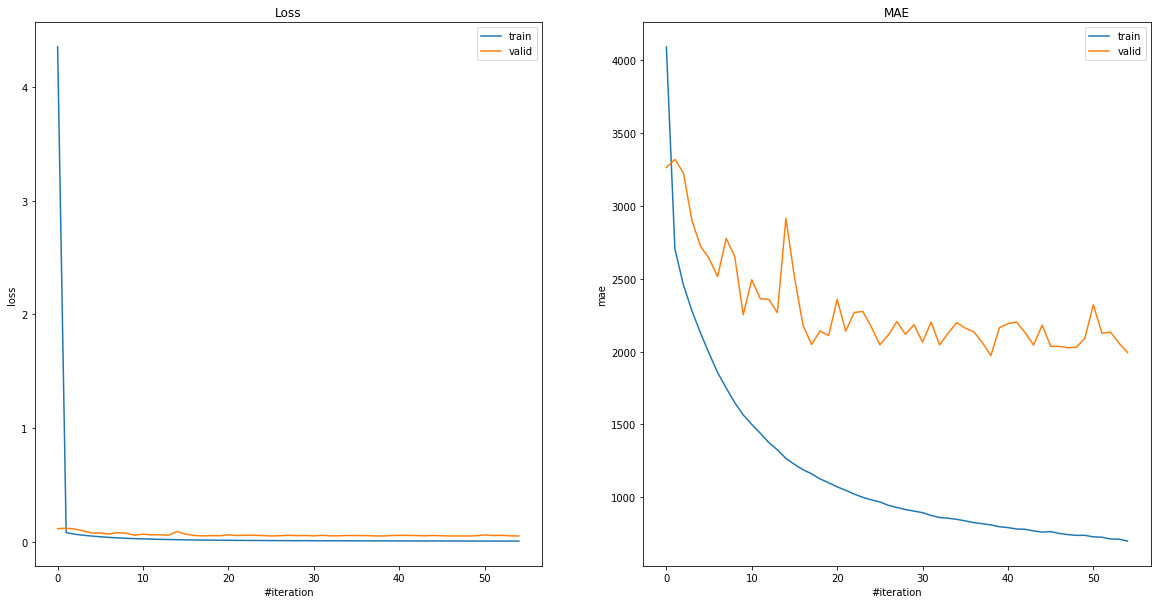

Final eval:



	Loss:	0.04964
	MAE:	1971.98824





In [47]:
plot_metrics({"Loss": {"train": train_losses,
                       "valid": val_losses},
              "MAE": {"train": train_mae_list,
                      "valid": val_mae_list}})
model.load_state_dict(best_model_dict)
evaluate(model, data_val, use_cuda=True)

## Moar conv layers + batchnorm + early stopping

In [48]:
title_encoder = TitleEncoder(
    in_size=256, out_size=64,
    convolution_blocks=nn.Sequential(
    ConvPoolBlock(256, 128, kernel_size=2, padding=2, use_bn=True, global_pool=False),
    ConvPoolBlock(128, 64, kernel_size=2, padding=2, use_bn=True, global_pool=False),
    ConvPoolBlock(64, 64, kernel_size=3, padding=1, use_bn=True)))
desc_encoder = JobDescriptionEncoder(in_size=256, out_size=64,
    convolution_blocks=nn.Sequential(
    ConvPoolBlock(256, 128, kernel_size=2, padding=1, use_bn=True, global_pool=False),
    ConvPoolBlock(128, 64, kernel_size=2, padding=1, use_bn=True, global_pool=False),
    ConvPoolBlock(64, 64, kernel_size=3, padding=1, use_bn=True)))
model = FullNetwork(title_encoder, desc_encoder, use_bn=True)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000
max_len = 100
batch_size = 32
batches_per_epoch = None
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val,
                                                        num_epochs,
                                                        batch_size, batches_per_epoch,
                                                        opt, use_cuda=True,
                                                        early_stopping_iters=15)

Training:



	Loss:	4.35356
	MAE:	4138.05730



Validation:



	Loss:	0.12217
	MAE:	3423.82869
0



Training:



	Loss:	0.07900
	MAE:	2701.96784



Validation:



	Loss:	0.08680
	MAE:	2895.35992
0



Training:



	Loss:	0.06620
	MAE:	2468.37986



Validation:



	Loss:	0.09498
	MAE:	3034.08499
1



Training:



	Loss:	0.05715
	MAE:	2284.50744



Validation:



	Loss:	0.09756
	MAE:	3147.79072
2



Training:



	Loss:	0.05051
	MAE:	2149.38601



Validation:



	Loss:	0.10472
	MAE:	3193.38616
3



Training:



	Loss:	0.04378
	MAE:	2001.15484



Validation:



	Loss:	0.06767
	MAE:	2546.41817
0



Training:



	Loss:	0.03800
	MAE:	1856.92752



Validation:



	Loss:	0.11433
	MAE:	3389.35028
1



Training:



	Loss:	0.03331
	MAE:	1735.61272



Validation:



	Loss:	0.08240
	MAE:	2866.32017
2



Training:



	Loss:	0.02915
	MAE:	1625.76719



Validation:



	Loss:	0.08278
	MAE:	2849.49735
3



Training:



	Loss:	0.02586
	MAE:	1535.92747



Validation:



	Loss:	0.09469
	MAE:	3048.16047
4



Training:



	Loss:	0.02305
	MAE:	1455.90611



Validation:



	Loss:	0.07098
	MAE:	2640.45536
5



Training:



	Loss:	0.02051
	MAE:	1376.99241



Validation:



	Loss:	0.06778
	MAE:	2569.64188
6



Training:



	Loss:	0.01945
	MAE:	1335.42182



Validation:



	Loss:	0.07808
	MAE:	2743.37039
7



Training:



	Loss:	0.01669
	MAE:	1256.24224



Validation:



	Loss:	0.07008
	MAE:	2614.94657
8



Training:



	Loss:	0.01532
	MAE:	1205.04418



Validation:



	Loss:	0.07205
	MAE:	2649.33056
9



Training:



	Loss:	0.01432
	MAE:	1157.86353



Validation:



	Loss:	0.08682
	MAE:	2935.25111
10



Training:



	Loss:	0.01324
	MAE:	1118.42098



Validation:



	Loss:	0.06239
	MAE:	2430.44224
0



Training:



	Loss:	0.01196
	MAE:	1071.25805



Validation:



	Loss:	0.05928
	MAE:	2375.58810
0



Training:



	Loss:	0.01162
	MAE:	1043.29307



Validation:



	Loss:	0.06307
	MAE:	2403.60242
1



Training:



	Loss:	0.01070
	MAE:	1015.22791



Validation:



	Loss:	0.05224
	MAE:	2125.98144
0



Training:



	Loss:	0.01015
	MAE:	991.12736



Validation:



	Loss:	0.05870
	MAE:	2338.67288
1



Training:



	Loss:	0.00958
	MAE:	963.83334



Validation:



	Loss:	0.05914
	MAE:	2355.04107
2



Training:



	Loss:	0.00918
	MAE:	943.47650



Validation:



	Loss:	0.06584
	MAE:	2525.14801
3



Training:



	Loss:	0.00860
	MAE:	913.82312



Validation:



	Loss:	0.07068
	MAE:	2656.52499
4



Training:



	Loss:	0.00838
	MAE:	900.22932



Validation:



	Loss:	0.05896
	MAE:	2317.62534
5



Training:



	Loss:	0.00789
	MAE:	878.19588



Validation:



	Loss:	0.05454
	MAE:	2223.29150
6



Training:



	Loss:	0.00757
	MAE:	861.06182



Validation:



	Loss:	0.06526
	MAE:	2520.79482
7



Training:



	Loss:	0.00730
	MAE:	843.42759



Validation:



	Loss:	0.05325
	MAE:	2190.39376
8



Training:



	Loss:	0.00710
	MAE:	833.59290



Validation:



	Loss:	0.06042
	MAE:	2406.35380
9



Training:



	Loss:	0.00681
	MAE:	810.13263



Validation:



	Loss:	0.07405
	MAE:	2703.95230
10



Training:



	Loss:	0.00662
	MAE:	803.83688



Validation:



	Loss:	0.05456
	MAE:	2241.91054
11



Training:



	Loss:	0.00639
	MAE:	792.67492



Validation:



	Loss:	0.05771
	MAE:	2324.29259
12



Training:



	Loss:	0.00611
	MAE:	773.01658



Validation:



	Loss:	0.05402
	MAE:	2223.38141
13



Training:



	Loss:	0.00593
	MAE:	762.95953



Validation:



	Loss:	0.05503
	MAE:	2249.00588
14



Training:



	Loss:	0.00579
	MAE:	753.73805



Validation:



	Loss:	0.05966
	MAE:	2377.69301
15



Training:



	Loss:	0.00567
	MAE:	746.39995



Validation:



	Loss:	0.05134
	MAE:	2120.80978
0



Training:



	Loss:	0.00560
	MAE:	741.42453



Validation:



	Loss:	0.06286
	MAE:	2467.08108
1



Training:



	Loss:	0.00532
	MAE:	724.00352



Validation:



	Loss:	0.05457
	MAE:	2233.11611
2



Training:



	Loss:	0.00529
	MAE:	718.47090



Validation:



	Loss:	0.06667
	MAE:	2575.98079
3



Training:



	Loss:	0.00506
	MAE:	704.69231



Validation:



	Loss:	0.04797
	MAE:	1977.97787
0



Training:



	Loss:	0.00507
	MAE:	702.02202



Validation:



	Loss:	0.05179
	MAE:	2125.59018
1



Training:



	Loss:	0.00487
	MAE:	688.13737



Validation:



	Loss:	0.05724
	MAE:	2287.74079
2



Training:



	Loss:	0.00474
	MAE:	682.12166



Validation:



	Loss:	0.05391
	MAE:	2213.50945
3



Training:



	Loss:	0.00470
	MAE:	679.22579



Validation:



	Loss:	0.05643
	MAE:	2260.49630
4



Training:



	Loss:	0.00464
	MAE:	673.41053



Validation:



	Loss:	0.05326
	MAE:	2189.45479
5



Training:



	Loss:	0.00453
	MAE:	664.87808



Validation:



	Loss:	0.05632
	MAE:	2273.31073
6



Training:



	Loss:	0.00441
	MAE:	658.07078



Validation:



	Loss:	0.05471
	MAE:	2224.78670
7



Training:



	Loss:	0.00431
	MAE:	650.57827



Validation:



	Loss:	0.05768
	MAE:	2313.36796
8



Training:



	Loss:	0.00427
	MAE:	646.56518



Validation:



	Loss:	0.05731
	MAE:	2301.48323
9



Training:



	Loss:	0.00414
	MAE:	637.31874



Validation:



	Loss:	0.05442
	MAE:	2230.23713
10



Training:



	Loss:	0.00403
	MAE:	631.38510



Validation:



	Loss:	0.05255
	MAE:	2158.69775
11



Training:



	Loss:	0.00404
	MAE:	630.04996



Validation:



	Loss:	0.05667
	MAE:	2304.87907
12



Training:



	Loss:	0.00400
	MAE:	624.35097



Validation:



	Loss:	0.05467
	MAE:	2208.33142
13



Training:



	Loss:	0.00385
	MAE:	614.57632



Validation:



	Loss:	0.04717
	MAE:	1968.75012
0



Training:



	Loss:	0.00379
	MAE:	610.16738



Validation:



	Loss:	0.05442
	MAE:	2241.29288
1



Training:



	Loss:	0.00375
	MAE:	604.51288



Validation:



	Loss:	0.05426
	MAE:	2212.96504
2



Training:



	Loss:	0.00375
	MAE:	606.59969



Validation:



	Loss:	0.05576
	MAE:	2268.36424
3



Training:



	Loss:	0.00373
	MAE:	600.46370



Validation:



	Loss:	0.04973
	MAE:	2046.33812
4



Training:



	Loss:	0.00368
	MAE:	597.86070



Validation:



	Loss:	0.05323
	MAE:	2195.33706
5



Training:



	Loss:	0.00364
	MAE:	590.54582



Validation:



	Loss:	0.05490
	MAE:	2253.36763
6



Training:



	Loss:	0.00349
	MAE:	584.02245



Validation:



	Loss:	0.05097
	MAE:	2120.80874
7



Training:



	Loss:	0.00347
	MAE:	583.51659



Validation:



	Loss:	0.05315
	MAE:	2201.92200
8



Training:



	Loss:	0.00355
	MAE:	583.67197



Validation:



	Loss:	0.05331
	MAE:	2180.12320
9



Training:



	Loss:	0.00347
	MAE:	580.35129



Validation:



	Loss:	0.06136
	MAE:	2436.84270
10



Training:



	Loss:	0.00335
	MAE:	571.99184



Validation:



	Loss:	0.05405
	MAE:	2216.05104
11



Training:



	Loss:	0.00327
	MAE:	566.45412



Validation:



	Loss:	0.05781
	MAE:	2336.08361
12



Training:



	Loss:	0.00327
	MAE:	565.82177



Validation:



	Loss:	0.04881
	MAE:	2034.04400
13



Training:



	Loss:	0.00319
	MAE:	557.64480



Validation:



	Loss:	0.05212
	MAE:	2139.54101
14



Training:



	Loss:	0.00318
	MAE:	556.36802



Validation:



	Loss:	0.04950
	MAE:	2057.03421
15



Training:



	Loss:	0.00310
	MAE:	551.40901



Validation:



	Loss:	0.05037
	MAE:	2084.69841
16





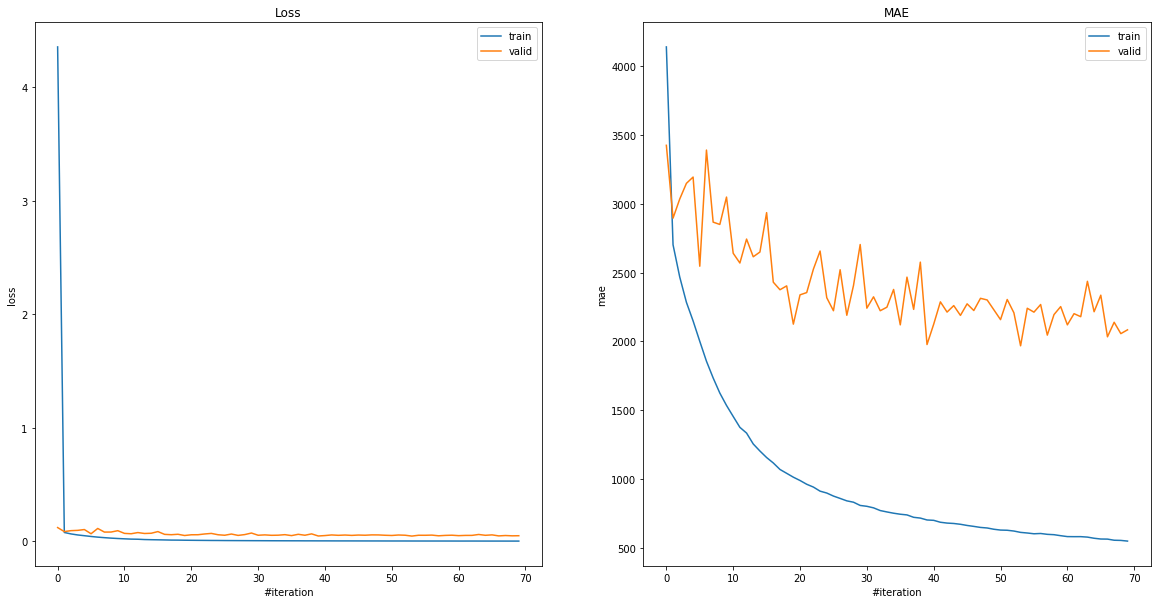

Final eval:



	Loss:	0.04717
	MAE:	1968.75012





In [49]:
plot_metrics({"Loss": {"train": train_losses,
                       "valid": val_losses},
              "MAE": {"train": train_mae_list,
                      "valid": val_mae_list}})
model.load_state_dict(best_model_dict)
evaluate(model, data_val, use_cuda=True)

## Less layers than before + batchnorm + early stopping

In [50]:
title_encoder = TitleEncoder(
    in_size=128, out_size=64,
    convolution_blocks=nn.Sequential(
    ConvPoolBlock(128, 64, kernel_size=2, padding=2, use_bn=True, global_pool=False),
    ConvPoolBlock(64, 64, kernel_size=3, padding=1, use_bn=True)))
desc_encoder = JobDescriptionEncoder(in_size=128, out_size=64,
    convolution_blocks=nn.Sequential(
    ConvPoolBlock(128, 64, kernel_size=2, padding=1, use_bn=True, global_pool=False),
    ConvPoolBlock(64, 64, kernel_size=3, padding=1, use_bn=True)))
model = FullNetwork(title_encoder, desc_encoder, use_bn=True)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000
max_len = 100
batch_size = 32
batches_per_epoch = None
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val,
                                                        num_epochs,
                                                        batch_size, batches_per_epoch,
                                                        opt, use_cuda=True,
                                                        early_stopping_iters=15)

Training:



	Loss:	4.51644
	MAE:	4272.26206



Validation:



	Loss:	0.13186
	MAE:	3409.66394
0



Training:



	Loss:	0.08626
	MAE:	2813.91889



Validation:



	Loss:	0.12468
	MAE:	3188.12015
0



Training:



	Loss:	0.07250
	MAE:	2570.78360



Validation:



	Loss:	0.10071
	MAE:	3075.39917
0



Training:



	Loss:	0.06233
	MAE:	2372.77808



Validation:



	Loss:	0.06298
	MAE:	2405.21853
0



Training:



	Loss:	0.05492
	MAE:	2219.77165



Validation:



	Loss:	0.07767
	MAE:	2680.92300
1



Training:



	Loss:	0.04870
	MAE:	2086.41191



Validation:



	Loss:	0.08522
	MAE:	2919.65556
2



Training:



	Loss:	0.04293
	MAE:	1956.75526



Validation:



	Loss:	0.07259
	MAE:	2698.90292
3



Training:



	Loss:	0.03819
	MAE:	1845.69354



Validation:



	Loss:	0.06734
	MAE:	2540.46987
4



Training:



	Loss:	0.03411
	MAE:	1733.92422



Validation:



	Loss:	0.05531
	MAE:	2158.73855
0



Training:



	Loss:	0.02990
	MAE:	1634.60483



Validation:



	Loss:	0.06066
	MAE:	2405.42683
1



Training:



	Loss:	0.02676
	MAE:	1543.84007



Validation:



	Loss:	0.05572
	MAE:	2279.62535
2



Training:



	Loss:	0.02389
	MAE:	1463.50928



Validation:



	Loss:	0.06366
	MAE:	2435.54181
3



Training:



	Loss:	0.02123
	MAE:	1378.69271



Validation:



	Loss:	0.06091
	MAE:	2365.66321
4



Training:



	Loss:	0.01935
	MAE:	1325.96968



Validation:



	Loss:	0.05534
	MAE:	2252.35969
5



Training:



	Loss:	0.01762
	MAE:	1265.12142



Validation:



	Loss:	0.05664
	MAE:	2308.21755
6



Training:



	Loss:	0.01603
	MAE:	1211.93637



Validation:



	Loss:	0.04961
	MAE:	2050.28447
0



Training:



	Loss:	0.01485
	MAE:	1169.10083



Validation:



	Loss:	0.06564
	MAE:	2500.48203
1



Training:



	Loss:	0.01377
	MAE:	1122.12150



Validation:



	Loss:	0.05500
	MAE:	2181.35509
2



Training:



	Loss:	0.01262
	MAE:	1079.74235



Validation:



	Loss:	0.05854
	MAE:	2328.46092
3



Training:



	Loss:	0.01185
	MAE:	1048.06011



Validation:



	Loss:	0.06646
	MAE:	2542.27919
4



Training:



	Loss:	0.01112
	MAE:	1015.77875



Validation:



	Loss:	0.05257
	MAE:	2177.38981
5



Training:



	Loss:	0.01048
	MAE:	990.04634



Validation:



	Loss:	0.05583
	MAE:	2282.83861
6



Training:



	Loss:	0.00998
	MAE:	964.84151



Validation:



	Loss:	0.05543
	MAE:	2246.23975
7



Training:



	Loss:	0.00937
	MAE:	936.97137



Validation:



	Loss:	0.05370
	MAE:	2191.42691
8



Training:



	Loss:	0.00977
	MAE:	927.17485



Validation:



	Loss:	0.05387
	MAE:	2112.78251
9



Training:



	Loss:	0.00851
	MAE:	891.62389



Validation:



	Loss:	0.06105
	MAE:	2329.59908
10



Training:



	Loss:	0.00847
	MAE:	879.09993



Validation:



	Loss:	0.05014
	MAE:	2057.81983
11



Training:



	Loss:	0.00785
	MAE:	860.69089



Validation:



	Loss:	0.05077
	MAE:	2118.11245
12



Training:



	Loss:	0.00750
	MAE:	843.57813



Validation:



	Loss:	0.05588
	MAE:	2236.07015
13



Training:



	Loss:	0.00734
	MAE:	832.29911



Validation:



	Loss:	0.05036
	MAE:	2063.63449
14



Training:



	Loss:	0.00712
	MAE:	821.78863



Validation:



	Loss:	0.05099
	MAE:	2121.55498
15



Training:



	Loss:	0.00683
	MAE:	805.41938



Validation:



	Loss:	0.06085
	MAE:	2358.85234
16





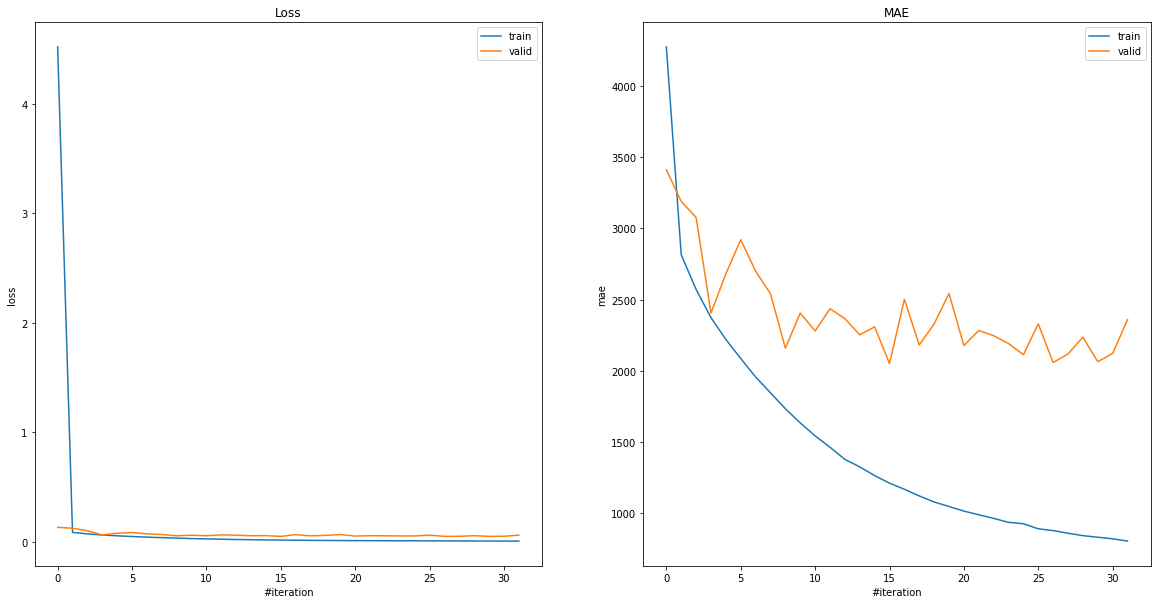

Final eval:



	Loss:	0.04961
	MAE:	2050.28447





In [51]:
plot_metrics({"Loss": {"train": train_losses,
                       "valid": val_losses},
              "MAE": {"train": train_mae_list,
                      "valid": val_mae_list}})
model.load_state_dict(best_model_dict)
evaluate(model, data_val, use_cuda=True)

## Asymmetric smaller architecture with batchnorm and early stopping

In [70]:
title_encoder = TitleEncoder(
    in_size=64, out_size=64,
    convolution_blocks=nn.Sequential(
    ConvPoolBlock(64, 64, kernel_size=3, padding=1, use_bn=True)))
desc_encoder = JobDescriptionEncoder(in_size=64, out_size=64,
    convolution_blocks=nn.Sequential(
    ConvPoolBlock(64, 64, kernel_size=2, padding=1, use_bn=True, global_pool=False),
    ConvPoolBlock(64, 64, kernel_size=3, padding=1, use_bn=True)))
model = FullNetwork(title_encoder, desc_encoder, use_bn=True)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000
max_len = 100
batch_size = 512
batches_per_epoch = None
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val,
                                                        num_epochs,
                                                        batch_size, batches_per_epoch,
                                                        opt, use_cuda=True,
                                                        early_stopping_iters=15)

Training:



	Loss:	61.22179
	MAE:	12519.89796



Validation:



	Loss:	14.50205
	MAE:	12230.98773
0



Training:



	Loss:	2.67445
	MAE:	7464.20024



Validation:



	Loss:	0.12656
	MAE:	3418.63801
0



Training:



	Loss:	0.10780
	MAE:	3114.71252



Validation:



	Loss:	0.08843
	MAE:	2824.67950
0



Training:



	Loss:	0.08652
	MAE:	2797.32359



Validation:



	Loss:	0.08962
	MAE:	2815.98917
1



Training:



	Loss:	0.07533
	MAE:	2608.23834



Validation:



	Loss:	0.08147
	MAE:	2681.33644
0



Training:



	Loss:	0.06790
	MAE:	2487.57480



Validation:



	Loss:	0.07417
	MAE:	2547.72544
0



Training:



	Loss:	0.06076
	MAE:	2351.45602



Validation:



	Loss:	0.07288
	MAE:	2521.85384
0



Training:



	Loss:	0.05542
	MAE:	2248.89263



Validation:



	Loss:	0.06931
	MAE:	2455.41891
0



Training:



	Loss:	0.05034
	MAE:	2144.26684



Validation:



	Loss:	0.06655
	MAE:	2405.39108
0



Training:



	Loss:	0.04624
	MAE:	2058.17852



Validation:



	Loss:	0.06683
	MAE:	2424.82753
1



Training:



	Loss:	0.04290
	MAE:	1987.38062



Validation:



	Loss:	0.06577
	MAE:	2433.69195
0



Training:



	Loss:	0.03977
	MAE:	1915.95722



Validation:



	Loss:	0.06383
	MAE:	2350.26910
0



Training:



	Loss:	0.03595
	MAE:	1821.47226



Validation:



	Loss:	0.06450
	MAE:	2362.18245
1



Training:



	Loss:	0.03331
	MAE:	1758.28619



Validation:



	Loss:	0.06428
	MAE:	2345.59740
2



Training:



	Loss:	0.03046
	MAE:	1678.98530



Validation:



	Loss:	0.06399
	MAE:	2359.89323
3



Training:



	Loss:	0.02878
	MAE:	1638.10762



Validation:



	Loss:	0.06142
	MAE:	2287.72696
0



Training:



	Loss:	0.02662
	MAE:	1574.23559



Validation:



	Loss:	0.06280
	MAE:	2363.39559
1



Training:



	Loss:	0.02392
	MAE:	1492.58708



Validation:



	Loss:	0.06205
	MAE:	2324.79248
2



Training:



	Loss:	0.02232
	MAE:	1445.39559



Validation:



	Loss:	0.06245
	MAE:	2333.78910
3



Training:



	Loss:	0.02069
	MAE:	1393.00610



Validation:



	Loss:	0.06073
	MAE:	2265.56253
0



Training:



	Loss:	0.01925
	MAE:	1343.13304



Validation:



	Loss:	0.06166
	MAE:	2307.21432
1



Training:



	Loss:	0.01779
	MAE:	1292.87503



Validation:



	Loss:	0.06071
	MAE:	2259.72478
0



Training:



	Loss:	0.01659
	MAE:	1252.11271



Validation:



	Loss:	0.06087
	MAE:	2271.68484
1



Training:



	Loss:	0.01556
	MAE:	1210.72794



Validation:



	Loss:	0.06123
	MAE:	2292.48423
2



Training:



	Loss:	0.01430
	MAE:	1163.11168



Validation:



	Loss:	0.06168
	MAE:	2265.11211
3



Training:



	Loss:	0.01352
	MAE:	1129.97319



Validation:



	Loss:	0.06821
	MAE:	2382.45486
4



Training:



	Loss:	0.01285
	MAE:	1102.04956



Validation:



	Loss:	0.05978
	MAE:	2237.65623
0



Training:



	Loss:	0.01194
	MAE:	1064.42599



Validation:



	Loss:	0.05943
	MAE:	2238.59825
0



Training:



	Loss:	0.01133
	MAE:	1038.15512



Validation:



	Loss:	0.05912
	MAE:	2222.32511
0



Training:



	Loss:	0.01057
	MAE:	1001.61437



Validation:



	Loss:	0.06052
	MAE:	2222.14401
1



Training:



	Loss:	0.01030
	MAE:	989.49465



Validation:



	Loss:	0.06068
	MAE:	2220.97583
2



Training:



	Loss:	0.00964
	MAE:	955.28899



Validation:



	Loss:	0.06023
	MAE:	2212.45735
3



Training:



	Loss:	0.00924
	MAE:	936.76031



Validation:



	Loss:	0.06478
	MAE:	2312.00784
4



Training:



	Loss:	0.00875
	MAE:	910.91881



Validation:



	Loss:	0.05894
	MAE:	2201.04726
0



Training:



	Loss:	0.00837
	MAE:	892.42866



Validation:



	Loss:	0.06178
	MAE:	2323.45363
1



Training:



	Loss:	0.00777
	MAE:	861.18294



Validation:



	Loss:	0.06121
	MAE:	2248.58845
2



Training:



	Loss:	0.00760
	MAE:	849.20345



Validation:



	Loss:	0.06067
	MAE:	2253.02604
3



Training:



	Loss:	0.00724
	MAE:	831.41313



Validation:



	Loss:	0.05992
	MAE:	2231.72465
4



Training:



	Loss:	0.00684
	MAE:	807.80745



Validation:



	Loss:	0.05880
	MAE:	2211.52478
0



Training:



	Loss:	0.00659
	MAE:	793.93962



Validation:



	Loss:	0.05887
	MAE:	2204.32048
1



Training:



	Loss:	0.00631
	MAE:	774.75522



Validation:



	Loss:	0.05906
	MAE:	2203.90702
2



Training:



	Loss:	0.00611
	MAE:	760.21801



Validation:



	Loss:	0.05789
	MAE:	2169.06548
0



Training:



	Loss:	0.00603
	MAE:	758.25946



Validation:



	Loss:	0.05847
	MAE:	2171.17013
1



Training:



	Loss:	0.00564
	MAE:	731.41571



Validation:



	Loss:	0.05778
	MAE:	2160.43203
0



Training:



	Loss:	0.00544
	MAE:	719.79641



Validation:



	Loss:	0.06013
	MAE:	2256.83661
1



Training:



	Loss:	0.00541
	MAE:	717.91003



Validation:



	Loss:	0.06017
	MAE:	2189.81795
2



Training:



	Loss:	0.00528
	MAE:	709.27305



Validation:



	Loss:	0.05720
	MAE:	2157.43215
0



Training:



	Loss:	0.00521
	MAE:	708.29285



Validation:



	Loss:	0.05835
	MAE:	2194.41321
1



Training:



	Loss:	0.00487
	MAE:	681.37071



Validation:



	Loss:	0.05852
	MAE:	2183.94337
2



Training:



	Loss:	0.00505
	MAE:	696.16095



Validation:



	Loss:	0.05856
	MAE:	2199.06185
3



Training:



	Loss:	0.00465
	MAE:	669.75540



Validation:



	Loss:	0.05837
	MAE:	2164.13183
4



Training:



	Loss:	0.00455
	MAE:	659.65556



Validation:



	Loss:	0.05951
	MAE:	2197.25783
5



Training:



	Loss:	0.00451
	MAE:	658.05989



Validation:



	Loss:	0.05785
	MAE:	2153.58454
6



Training:



	Loss:	0.00442
	MAE:	650.43879



Validation:



	Loss:	0.05761
	MAE:	2155.02056
7



Training:



	Loss:	0.00441
	MAE:	647.41398



Validation:



	Loss:	0.05807
	MAE:	2183.11646
8



Training:



	Loss:	0.00418
	MAE:	630.20200



Validation:



	Loss:	0.05903
	MAE:	2165.10626
9



Training:



	Loss:	0.00431
	MAE:	644.71797



Validation:



	Loss:	0.05717
	MAE:	2149.43259
0



Training:



	Loss:	0.00406
	MAE:	625.77674



Validation:



	Loss:	0.05596
	MAE:	2117.09830
0



Training:



	Loss:	0.00387
	MAE:	609.25752



Validation:



	Loss:	0.05723
	MAE:	2133.34907
1



Training:



	Loss:	0.00374
	MAE:	602.45590



Validation:



	Loss:	0.05692
	MAE:	2135.00800
2



Training:



	Loss:	0.00366
	MAE:	591.86881



Validation:



	Loss:	0.05818
	MAE:	2149.96155
3



Training:



	Loss:	0.00366
	MAE:	593.19197



Validation:



	Loss:	0.05747
	MAE:	2145.53709
4



Training:



	Loss:	0.00360
	MAE:	589.49728



Validation:



	Loss:	0.05683
	MAE:	2142.70075
5



Training:



	Loss:	0.00365
	MAE:	592.48265



Validation:



	Loss:	0.05742
	MAE:	2137.03163
6



Training:



	Loss:	0.00348
	MAE:	580.72370



Validation:



	Loss:	0.05594
	MAE:	2109.64967
0



Training:



	Loss:	0.00330
	MAE:	568.11634



Validation:



	Loss:	0.05723
	MAE:	2154.46888
1



Training:



	Loss:	0.00332
	MAE:	565.02846



Validation:



	Loss:	0.05825
	MAE:	2152.88009
2



Training:



	Loss:	0.00332
	MAE:	563.60589



Validation:



	Loss:	0.05796
	MAE:	2162.73023
3



Training:



	Loss:	0.00330
	MAE:	566.95751



Validation:



	Loss:	0.05682
	MAE:	2123.07883
4



Training:



	Loss:	0.00328
	MAE:	563.08480



Validation:



	Loss:	0.05810
	MAE:	2148.25959
5



Training:



	Loss:	0.00331
	MAE:	566.92770



Validation:



	Loss:	0.05672
	MAE:	2131.21548
6



Training:



	Loss:	0.00309
	MAE:	545.86338



Validation:



	Loss:	0.05524
	MAE:	2098.77438
0



Training:



	Loss:	0.00283
	MAE:	524.02694



Validation:



	Loss:	0.05541
	MAE:	2105.13876
1



Training:



	Loss:	0.00307
	MAE:	547.25030



Validation:



	Loss:	0.05614
	MAE:	2114.36006
2



Training:



	Loss:	0.00304
	MAE:	547.62959



Validation:



	Loss:	0.05637
	MAE:	2141.26331
3



Training:



	Loss:	0.00292
	MAE:	530.82026



Validation:



	Loss:	0.05568
	MAE:	2102.89191
4



Training:



	Loss:	0.00294
	MAE:	532.10375



Validation:



	Loss:	0.05482
	MAE:	2085.08326
0



Training:



	Loss:	0.00275
	MAE:	513.39122



Validation:



	Loss:	0.05535
	MAE:	2096.76768
1



Training:



	Loss:	0.00283
	MAE:	523.61425



Validation:



	Loss:	0.05560
	MAE:	2084.30952
2



Training:



	Loss:	0.00287
	MAE:	528.70690



Validation:



	Loss:	0.05490
	MAE:	2081.08139
3



Training:



	Loss:	0.00280
	MAE:	521.31036



Validation:



	Loss:	0.05506
	MAE:	2089.11608
4



Training:



	Loss:	0.00277
	MAE:	519.22856



Validation:



	Loss:	0.05475
	MAE:	2073.64106
0



Training:



	Loss:	0.00265
	MAE:	507.30773



Validation:



	Loss:	0.05528
	MAE:	2098.06940
1



Training:



	Loss:	0.00263
	MAE:	506.42046



Validation:



	Loss:	0.05481
	MAE:	2090.42182
2



Training:



	Loss:	0.00270
	MAE:	509.84883



Validation:



	Loss:	0.05684
	MAE:	2134.99413
3



Training:



	Loss:	0.00266
	MAE:	509.40083



Validation:



	Loss:	0.05532
	MAE:	2102.28068
4



Training:



	Loss:	0.00250
	MAE:	493.70093



Validation:



	Loss:	0.05542
	MAE:	2094.86906
5



Training:



	Loss:	0.00267
	MAE:	514.40585



Validation:



	Loss:	0.05464
	MAE:	2071.17437
0



Training:



	Loss:	0.00241
	MAE:	483.11464



Validation:



	Loss:	0.05442
	MAE:	2074.54305
0



Training:



	Loss:	0.00256
	MAE:	502.71149



Validation:



	Loss:	0.05551
	MAE:	2100.90662
1



Training:



	Loss:	0.00255
	MAE:	498.37574



Validation:



	Loss:	0.05471
	MAE:	2084.29705
2



Training:



	Loss:	0.00243
	MAE:	486.84863



Validation:



	Loss:	0.05442
	MAE:	2069.14251
0



Training:



	Loss:	0.00247
	MAE:	490.59073



Validation:



	Loss:	0.05593
	MAE:	2092.77539
1



Training:



	Loss:	0.00236
	MAE:	479.83563



Validation:



	Loss:	0.05416
	MAE:	2064.21643
0



Training:



	Loss:	0.00232
	MAE:	474.69653



Validation:



	Loss:	0.05401
	MAE:	2058.80279
0



Training:



	Loss:	0.00231
	MAE:	475.19412



Validation:



	Loss:	0.05504
	MAE:	2105.43324
1



Training:



	Loss:	0.00235
	MAE:	479.02302



Validation:



	Loss:	0.05370
	MAE:	2052.89251
0



Training:



	Loss:	0.00224
	MAE:	465.58287



Validation:



	Loss:	0.05446
	MAE:	2064.18545
1



Training:



	Loss:	0.00221
	MAE:	464.66138



Validation:



	Loss:	0.05461
	MAE:	2068.82596
2



Training:



	Loss:	0.00232
	MAE:	477.47778



Validation:



	Loss:	0.05509
	MAE:	2110.32721
3



Training:



	Loss:	0.00222
	MAE:	467.46843



Validation:



	Loss:	0.05416
	MAE:	2074.08046
4



Training:



	Loss:	0.00218
	MAE:	464.00921



Validation:



	Loss:	0.05479
	MAE:	2066.97654
5



Training:



	Loss:	0.00225
	MAE:	467.46058



Validation:



	Loss:	0.05426
	MAE:	2062.50296
6



Training:



	Loss:	0.00230
	MAE:	474.81023



Validation:



	Loss:	0.05513
	MAE:	2106.77270
7



Training:



	Loss:	0.00213
	MAE:	455.96706



Validation:



	Loss:	0.05412
	MAE:	2070.16011
8



Training:



	Loss:	0.00223
	MAE:	466.56974



Validation:



	Loss:	0.05397
	MAE:	2067.62065
9



Training:



	Loss:	0.00215
	MAE:	460.17957



Validation:



	Loss:	0.05365
	MAE:	2054.04372
0



Training:



	Loss:	0.00213
	MAE:	458.51387



Validation:



	Loss:	0.05401
	MAE:	2063.66676
1



Training:



	Loss:	0.00212
	MAE:	459.30619



Validation:



	Loss:	0.05377
	MAE:	2057.53673
2



Training:



	Loss:	0.00215
	MAE:	458.19937



Validation:



	Loss:	0.05351
	MAE:	2050.47610
0



Training:



	Loss:	0.00199
	MAE:	441.00700



Validation:



	Loss:	0.05345
	MAE:	2049.59479
0



Training:



	Loss:	0.00207
	MAE:	451.49049



Validation:



	Loss:	0.05340
	MAE:	2055.28406
0



Training:



	Loss:	0.00217
	MAE:	461.36166



Validation:



	Loss:	0.05342
	MAE:	2047.33606
1



Training:



	Loss:	0.00204
	MAE:	448.76920



Validation:



	Loss:	0.05592
	MAE:	2106.43851
2



Training:



	Loss:	0.00205
	MAE:	448.52734



Validation:



	Loss:	0.05347
	MAE:	2044.58104
3



Training:



	Loss:	0.00198
	MAE:	440.53377



Validation:



	Loss:	0.05372
	MAE:	2049.01542
4



Training:



	Loss:	0.00190
	MAE:	431.20436



Validation:



	Loss:	0.05365
	MAE:	2052.25454
5



Training:



	Loss:	0.00186
	MAE:	426.41272



Validation:



	Loss:	0.05333
	MAE:	2063.25115
0



Training:



	Loss:	0.00198
	MAE:	443.57316



Validation:



	Loss:	0.05310
	MAE:	2033.44001
0



Training:



	Loss:	0.00190
	MAE:	433.83638



Validation:



	Loss:	0.05346
	MAE:	2042.85655
1



Training:



	Loss:	0.00187
	MAE:	427.58463



Validation:



	Loss:	0.05401
	MAE:	2065.31990
2



Training:



	Loss:	0.00187
	MAE:	427.60757



Validation:



	Loss:	0.05275
	MAE:	2034.91025
0



Training:



	Loss:	0.00194
	MAE:	438.14140



Validation:



	Loss:	0.05292
	MAE:	2037.72104
1



Training:



	Loss:	0.00178
	MAE:	417.36366



Validation:



	Loss:	0.05346
	MAE:	2059.01621
2



Training:



	Loss:	0.00200
	MAE:	436.02235



Validation:



	Loss:	0.05342
	MAE:	2038.22286
3



Training:



	Loss:	0.00189
	MAE:	430.06117



Validation:



	Loss:	0.05401
	MAE:	2050.87251
4



Training:



	Loss:	0.00190
	MAE:	430.47183



Validation:



	Loss:	0.05331
	MAE:	2039.82104
5



Training:



	Loss:	0.00193
	MAE:	439.49965



Validation:



	Loss:	0.05234
	MAE:	2021.45274
0



Training:



	Loss:	0.00189
	MAE:	433.81095



Validation:



	Loss:	0.05219
	MAE:	2018.44702
0



Training:



	Loss:	0.00174
	MAE:	411.92502



Validation:



	Loss:	0.05284
	MAE:	2036.21774
1



Training:



	Loss:	0.00175
	MAE:	416.21737



Validation:



	Loss:	0.05268
	MAE:	2026.02868
2



Training:



	Loss:	0.00174
	MAE:	414.58894



Validation:



	Loss:	0.05216
	MAE:	2015.33413
0



Training:



	Loss:	0.00185
	MAE:	425.65745



Validation:



	Loss:	0.05260
	MAE:	2027.27041
1



Training:



	Loss:	0.00170
	MAE:	408.68233



Validation:



	Loss:	0.05252
	MAE:	2031.46289
2



Training:



	Loss:	0.00175
	MAE:	417.80735



Validation:



	Loss:	0.05262
	MAE:	2027.94732
3



Training:



	Loss:	0.00167
	MAE:	405.88738



Validation:



	Loss:	0.05262
	MAE:	2026.78399
4



Training:



	Loss:	0.00185
	MAE:	426.05594



Validation:



	Loss:	0.05189
	MAE:	2013.45483
0



Training:



	Loss:	0.00168
	MAE:	403.53496



Validation:



	Loss:	0.05327
	MAE:	2048.21007
1



Training:



	Loss:	0.00173
	MAE:	414.60415



Validation:



	Loss:	0.05210
	MAE:	2021.85006
2



Training:



	Loss:	0.00172
	MAE:	412.07548



Validation:



	Loss:	0.05221
	MAE:	2022.00335
3



Training:



	Loss:	0.00176
	MAE:	417.41387



Validation:



	Loss:	0.05213
	MAE:	2017.29927
4



Training:



	Loss:	0.00163
	MAE:	400.35029



Validation:



	Loss:	0.05199
	MAE:	2021.06503
5



Training:



	Loss:	0.00168
	MAE:	405.72298



Validation:



	Loss:	0.05277
	MAE:	2046.06382
6



Training:



	Loss:	0.00168
	MAE:	405.93259



Validation:



	Loss:	0.05216
	MAE:	2012.63992
7



Training:



	Loss:	0.00178
	MAE:	418.95670



Validation:



	Loss:	0.05188
	MAE:	2009.97131
0



Training:



	Loss:	0.00162
	MAE:	395.26652



Validation:



	Loss:	0.05328
	MAE:	2033.95034
1



Training:



	Loss:	0.00169
	MAE:	407.82199



Validation:



	Loss:	0.05152
	MAE:	2005.36071
0



Training:



	Loss:	0.00167
	MAE:	411.32336



Validation:



	Loss:	0.05236
	MAE:	2010.50195
1



Training:



	Loss:	0.00168
	MAE:	407.43267



Validation:



	Loss:	0.05205
	MAE:	2010.77519
2



Training:



	Loss:	0.00170
	MAE:	406.86929



Validation:



	Loss:	0.05190
	MAE:	2009.59460
3



Training:



	Loss:	0.00153
	MAE:	387.11184



Validation:



	Loss:	0.05167
	MAE:	2007.30778
4



Training:



	Loss:	0.00157
	MAE:	397.66055



Validation:



	Loss:	0.05205
	MAE:	2007.80840
5



Training:



	Loss:	0.00160
	MAE:	398.95645



Validation:



	Loss:	0.05139
	MAE:	1999.51464
0



Training:



	Loss:	0.00156
	MAE:	394.96223



Validation:



	Loss:	0.05182
	MAE:	2006.09778
1



Training:



	Loss:	0.00161
	MAE:	397.96145



Validation:



	Loss:	0.05215
	MAE:	2013.99656
2



Training:



	Loss:	0.00157
	MAE:	394.66311



Validation:



	Loss:	0.05268
	MAE:	2022.03528
3



Training:



	Loss:	0.00156
	MAE:	396.08939



Validation:



	Loss:	0.05151
	MAE:	2003.79081
4



Training:



	Loss:	0.00150
	MAE:	387.30006



Validation:



	Loss:	0.05155
	MAE:	1998.17144
5



Training:



	Loss:	0.00149
	MAE:	384.06894



Validation:



	Loss:	0.05187
	MAE:	2013.11217
6



Training:



	Loss:	0.00150
	MAE:	386.19290



Validation:



	Loss:	0.05140
	MAE:	1997.60774
7



Training:



	Loss:	0.00154
	MAE:	389.34524



Validation:



	Loss:	0.05163
	MAE:	2004.25516
8



Training:



	Loss:	0.00150
	MAE:	384.91193



Validation:



	Loss:	0.05145
	MAE:	1996.23051
9



Training:



	Loss:	0.00158
	MAE:	396.88415



Validation:



	Loss:	0.05176
	MAE:	2003.28214
10



Training:



	Loss:	0.00143
	MAE:	375.39780



Validation:



	Loss:	0.05120
	MAE:	1999.02041
0



Training:



	Loss:	0.00144
	MAE:	377.79966



Validation:



	Loss:	0.05154
	MAE:	1992.94720
1



Training:



	Loss:	0.00143
	MAE:	376.19441



Validation:



	Loss:	0.05158
	MAE:	1997.00999
2



Training:



	Loss:	0.00150
	MAE:	385.09064



Validation:



	Loss:	0.05135
	MAE:	2002.33847
3



Training:



	Loss:	0.00143
	MAE:	375.17550



Validation:



	Loss:	0.05126
	MAE:	1992.66222
4



Training:



	Loss:	0.00150
	MAE:	388.13943



Validation:



	Loss:	0.05159
	MAE:	1997.06893
5



Training:



	Loss:	0.00140
	MAE:	370.76960



Validation:



	Loss:	0.05144
	MAE:	1997.45759
6



Training:



	Loss:	0.00147
	MAE:	379.17521



Validation:



	Loss:	0.05109
	MAE:	1990.21783
0



Training:



	Loss:	0.00134
	MAE:	363.56210



Validation:



	Loss:	0.05106
	MAE:	1985.41834
0



Training:



	Loss:	0.00134
	MAE:	366.12248



Validation:



	Loss:	0.05128
	MAE:	2004.70776
1



Training:



	Loss:	0.00143
	MAE:	377.73284



Validation:



	Loss:	0.05126
	MAE:	2005.12299
2



Training:



	Loss:	0.00151
	MAE:	386.71395



Validation:



	Loss:	0.05189
	MAE:	2005.76429
3



Training:



	Loss:	0.00148
	MAE:	382.45305



Validation:



	Loss:	0.05095
	MAE:	1985.46849
0



Training:



	Loss:	0.00129
	MAE:	357.96719



Validation:



	Loss:	0.05132
	MAE:	1993.32610
1



Training:



	Loss:	0.00133
	MAE:	362.34964



Validation:



	Loss:	0.05090
	MAE:	1985.88113
0



Training:



	Loss:	0.00140
	MAE:	372.64282



Validation:



	Loss:	0.05155
	MAE:	2006.31305
1



Training:



	Loss:	0.00138
	MAE:	369.55985



Validation:



	Loss:	0.05124
	MAE:	1989.93477
2



Training:



	Loss:	0.00144
	MAE:	379.01404



Validation:



	Loss:	0.05096
	MAE:	1987.06627
3



Training:



	Loss:	0.00128
	MAE:	356.97210



Validation:



	Loss:	0.05080
	MAE:	1987.45573
0



Training:



	Loss:	0.00125
	MAE:	350.65306



Validation:



	Loss:	0.05128
	MAE:	2001.51910
1



Training:



	Loss:	0.00136
	MAE:	368.21351



Validation:



	Loss:	0.05088
	MAE:	1983.48168
2



Training:



	Loss:	0.00140
	MAE:	372.74463



Validation:



	Loss:	0.05122
	MAE:	1995.49215
3



Training:



	Loss:	0.00136
	MAE:	366.19421



Validation:



	Loss:	0.05032
	MAE:	1970.18266
0



Training:



	Loss:	0.00141
	MAE:	373.74892



Validation:



	Loss:	0.05151
	MAE:	2005.17048
1



Training:



	Loss:	0.00133
	MAE:	363.83520



Validation:



	Loss:	0.05097
	MAE:	1987.62329
2



Training:



	Loss:	0.00139
	MAE:	371.38496



Validation:



	Loss:	0.05059
	MAE:	1979.30475
3



Training:



	Loss:	0.00133
	MAE:	363.91107



Validation:



	Loss:	0.05071
	MAE:	1978.02996
4



Training:



	Loss:	0.00128
	MAE:	354.54997



Validation:



	Loss:	0.05109
	MAE:	1993.83610
5



Training:



	Loss:	0.00130
	MAE:	359.48791



Validation:



	Loss:	0.05124
	MAE:	1993.47042
6



Training:



	Loss:	0.00136
	MAE:	363.80853



Validation:



	Loss:	0.05261
	MAE:	2030.44523
7



Training:



	Loss:	0.00131
	MAE:	359.29182



Validation:



	Loss:	0.05059
	MAE:	1973.84168
8



Training:



	Loss:	0.00128
	MAE:	355.80677



Validation:



	Loss:	0.05071
	MAE:	1989.33832
9



Training:



	Loss:	0.00121
	MAE:	345.91337



Validation:



	Loss:	0.05093
	MAE:	1990.58827
10



Training:



	Loss:	0.00118
	MAE:	338.58958



Validation:



	Loss:	0.05277
	MAE:	2039.01193
11



Training:



	Loss:	0.00132
	MAE:	361.18787



Validation:



	Loss:	0.05106
	MAE:	1995.64094
12



Training:



	Loss:	0.00136
	MAE:	369.45422



Validation:



	Loss:	0.05053
	MAE:	1979.82644
13



Training:



	Loss:	0.00133
	MAE:	364.85042



Validation:



	Loss:	0.05048
	MAE:	1971.23776
14



Training:



	Loss:	0.00127
	MAE:	355.09032



Validation:



	Loss:	0.05039
	MAE:	1974.56821
15



Training:



	Loss:	0.00136
	MAE:	369.16323



Validation:



	Loss:	0.05035
	MAE:	1969.26937
16





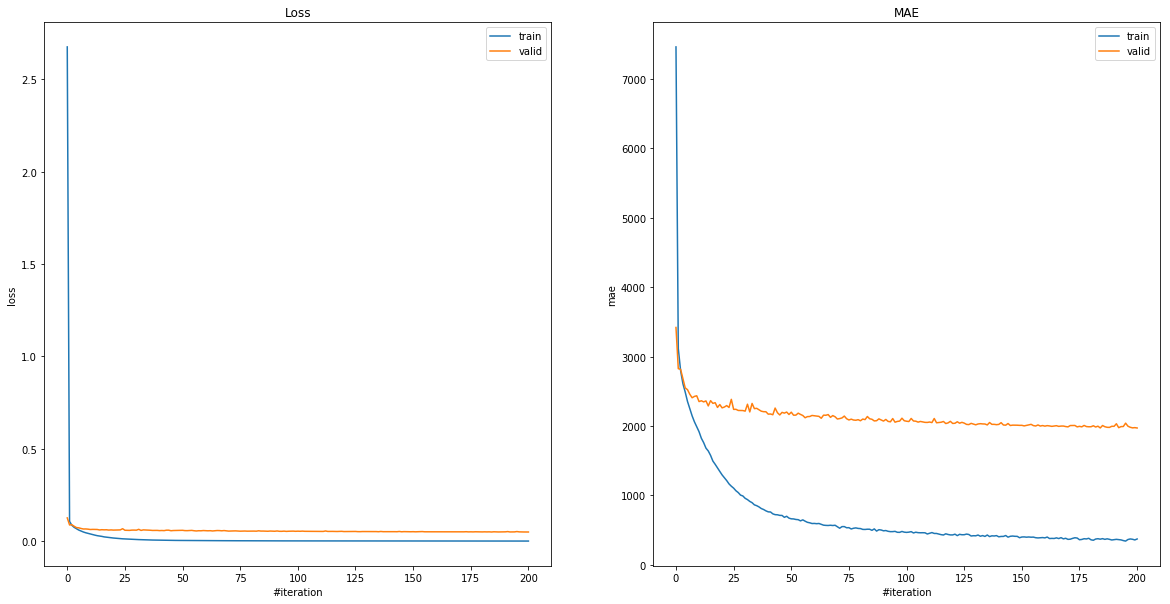

Final eval:



	Loss:	0.05032
	MAE:	1970.18266





In [72]:
plot_metrics({"Loss": {"train": train_losses[1:],
                       "valid": val_losses[1:]},
              "MAE": {"train": train_mae_list[1:],
                      "valid": val_mae_list[1:]}})
model.load_state_dict(best_model_dict)
evaluate(model, data_val, batch_size=batch_size, use_cuda=True)

## Baseline + batchnorm + dropout

In [62]:
title_encoder = TitleEncoder(convolution_blocks=ConvPoolBlock(64, 64, 
                                                              kernel_size=3,
                                                              padding=1, use_bn=True,
                                                              use_dropout=True,
                                                              dropout_p=0.2))

desc_encoder = JobDescriptionEncoder(convolution_blocks=ConvPoolBlock(64, 64, 
                                                                      kernel_size=3,
                                                                      padding=1, use_bn=True,
                                                                      use_dropout=True,
                                                                      dropout_p=0.2))
model = FullNetwork(title_encoder, desc_encoder, use_bn=True, use_dropout=True, dropout_p=0.2)
opt = torch.optim.Adam(model.parameters(), lr=0.1)
num_epochs = 1000
max_len = 100
batch_size = 512
batches_per_epoch = None
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val, num_epochs,
                                                       batch_size, batches_per_epoch,
                                                       opt, use_cuda=True,
                                                       early_stopping_iters=15)

Training:




	Loss:	3.24248
	MAE:	173022.92350



Validation:



	Loss:	0.13414
	MAE:	3507.73247
0



Training:



	Loss:	0.35257
	MAE:	5609.33845



Validation:



	Loss:	0.08846
	MAE:	2896.47352
0



Training:



	Loss:	0.11814
	MAE:	3365.68890



Validation:



	Loss:	0.07332
	MAE:	2535.89190
0



Training:



	Loss:	0.08875
	MAE:	2904.97296



Validation:



	Loss:	0.07730
	MAE:	2659.25513
1



Training:



	Loss:	0.08196
	MAE:	2786.88575



Validation:



	Loss:	0.07095
	MAE:	2523.64862
0



Training:



	Loss:	0.07667
	MAE:	2701.58413



Validation:



	Loss:	0.06311
	MAE:	2295.74428
0



Training:



	Loss:	0.07183
	MAE:	2611.04499



Validation:



	Loss:	0.06198
	MAE:	2304.89294
0



Training:



	Loss:	0.06902
	MAE:	2569.08116



Validation:



	Loss:	0.06324
	MAE:	2341.69930
1



Training:



	Loss:	0.06624
	MAE:	2518.34718



Validation:



	Loss:	0.05993
	MAE:	2286.29753
0



Training:



	Loss:	0.06424
	MAE:	2487.74709



Validation:



	Loss:	0.05758
	MAE:	2189.22966
0



Training:



	Loss:	0.06302
	MAE:	2466.84900



Validation:



	Loss:	0.05955
	MAE:	2274.59711
1



Training:



	Loss:	0.06090
	MAE:	2420.80121



Validation:



	Loss:	0.05628
	MAE:	2184.17252
0



Training:



	Loss:	0.06137
	MAE:	2450.56112



Validation:



	Loss:	0.05779
	MAE:	2216.88594
1



Training:



	Loss:	0.05958
	MAE:	2412.24368



Validation:



	Loss:	0.05428
	MAE:	2093.24178
0



Training:



	Loss:	0.05693
	MAE:	2350.76071



Validation:



	Loss:	0.06034
	MAE:	2272.21695
1



Training:



	Loss:	0.05872
	MAE:	2404.88169



Validation:



	Loss:	0.05299
	MAE:	2062.22568
0



Training:



	Loss:	0.05681
	MAE:	2358.99607



Validation:



	Loss:	0.05463
	MAE:	2149.13142
1



Training:



	Loss:	0.05744
	MAE:	2383.09839



Validation:



	Loss:	0.05793
	MAE:	2234.76748
2



Training:



	Loss:	0.05400
	MAE:	2295.50671



Validation:



	Loss:	0.05168
	MAE:	2016.03903
0



Training:



	Loss:	0.05542
	MAE:	2341.94799



Validation:



	Loss:	0.05808
	MAE:	2236.09758
1



Training:



	Loss:	0.05413
	MAE:	2312.27026



Validation:



	Loss:	0.05781
	MAE:	2151.83482
2



Training:



	Loss:	0.05352
	MAE:	2299.60969



Validation:



	Loss:	0.06017
	MAE:	2198.39058
3



Training:



	Loss:	0.05533
	MAE:	2351.50491



Validation:



	Loss:	0.05446
	MAE:	2131.16353
4



Training:



	Loss:	0.05279
	MAE:	2292.04273



Validation:



	Loss:	0.05282
	MAE:	2086.35375
5



Training:



	Loss:	0.05213
	MAE:	2271.39917



Validation:



	Loss:	0.05196
	MAE:	2010.21049
6



Training:



	Loss:	0.05049
	MAE:	2235.65472



Validation:



	Loss:	0.05209
	MAE:	2001.56182
7



Training:



	Loss:	0.05129
	MAE:	2259.17483



Validation:



	Loss:	0.05466
	MAE:	2171.08727
8



Training:



	Loss:	0.04987
	MAE:	2223.69737



Validation:



	Loss:	0.06280
	MAE:	2426.96683
9



Training:



	Loss:	0.04969
	MAE:	2222.65931



Validation:



	Loss:	0.05550
	MAE:	2169.61056
10



Training:



	Loss:	0.05153
	MAE:	2271.94322



Validation:



	Loss:	0.06718
	MAE:	2532.76499
11



Training:



	Loss:	0.04794
	MAE:	2179.37692



Validation:



	Loss:	0.05263
	MAE:	2080.32600
12



Training:



	Loss:	0.04898
	MAE:	2211.38509



Validation:



	Loss:	0.05190
	MAE:	2032.60776
13



Training:



	Loss:	0.04779
	MAE:	2181.89928



Validation:



	Loss:	0.04966
	MAE:	1935.21908
0



Training:



	Loss:	0.04719
	MAE:	2165.06474



Validation:



	Loss:	0.05763
	MAE:	2235.85275
1



Training:



	Loss:	0.04780
	MAE:	2190.05864



Validation:



	Loss:	0.05019
	MAE:	1930.85578
2



Training:



	Loss:	0.04934
	MAE:	2233.24974



Validation:



	Loss:	0.05922
	MAE:	2327.80484
3



Training:



	Loss:	0.04530
	MAE:	2111.88237



Validation:



	Loss:	0.05444
	MAE:	2067.87897
4



Training:



	Loss:	0.04562
	MAE:	2131.18874



Validation:



	Loss:	0.06819
	MAE:	2604.23841
5



Training:



	Loss:	0.04602
	MAE:	2145.54708



Validation:



	Loss:	0.04904
	MAE:	1913.67452
0



Training:



	Loss:	0.04496
	MAE:	2107.57362



Validation:



	Loss:	0.04897
	MAE:	1903.66034
0



Training:



	Loss:	0.04731
	MAE:	2185.27277



Validation:



	Loss:	0.05933
	MAE:	2324.24894
1



Training:



	Loss:	0.04617
	MAE:	2148.21370



Validation:



	Loss:	0.04934
	MAE:	1904.57536
2



Training:



	Loss:	0.04409
	MAE:	2093.21646



Validation:



	Loss:	0.07455
	MAE:	2723.08880
3



Training:



	Loss:	0.04380
	MAE:	2082.77186



Validation:



	Loss:	0.05123
	MAE:	1977.57998
4



Training:



	Loss:	0.04403
	MAE:	2090.18800



Validation:



	Loss:	0.08291
	MAE:	3136.21090
5



Training:



	Loss:	0.04560
	MAE:	2141.64301



Validation:



	Loss:	0.07476
	MAE:	2810.31558
6



Training:



	Loss:	0.04466
	MAE:	2116.93679



Validation:



	Loss:	0.05981
	MAE:	2342.17409
7



Training:



	Loss:	0.04290
	MAE:	2065.49363



Validation:



	Loss:	0.05029
	MAE:	1938.51375
8



Training:



	Loss:	0.04472
	MAE:	2116.51229



Validation:



	Loss:	0.05812
	MAE:	2290.37876
9



Training:



	Loss:	0.04393
	MAE:	2096.21931



Validation:



	Loss:	0.05168
	MAE:	2029.98916
10



Training:



	Loss:	0.04088
	MAE:	2004.73329



Validation:



	Loss:	0.05482
	MAE:	2103.89580
11



Training:



	Loss:	0.04490
	MAE:	2131.67945



Validation:



	Loss:	0.05840
	MAE:	2240.01197
12



Training:



	Loss:	0.04217
	MAE:	2044.87195



Validation:



	Loss:	0.06547
	MAE:	2514.34845
13



Training:



	Loss:	0.04372
	MAE:	2096.04311



Validation:



	Loss:	0.04883
	MAE:	1893.85274
0



Training:



	Loss:	0.04162
	MAE:	2030.25921



Validation:



	Loss:	0.04969
	MAE:	1908.67680
1



Training:



	Loss:	0.04454
	MAE:	2124.50712



Validation:



	Loss:	0.05475
	MAE:	2109.14591
2



Training:



	Loss:	0.04287
	MAE:	2067.53549



Validation:



	Loss:	0.04868
	MAE:	1891.35215
0



Training:



	Loss:	0.04131
	MAE:	2026.75222



Validation:



	Loss:	0.05479
	MAE:	2185.07958
1



Training:



	Loss:	0.04288
	MAE:	2075.36322



Validation:



	Loss:	0.06023
	MAE:	2359.50217
2



Training:



	Loss:	0.04138
	MAE:	2030.74278



Validation:



	Loss:	0.04738
	MAE:	1848.09105
0



Training:



	Loss:	0.04097
	MAE:	2019.04065



Validation:



	Loss:	0.04931
	MAE:	1925.01803
1



Training:



	Loss:	0.04239
	MAE:	2061.96340



Validation:



	Loss:	0.05593
	MAE:	2131.62268
2



Training:



	Loss:	0.04257
	MAE:	2071.08312



Validation:



	Loss:	0.06399
	MAE:	2430.06591
3



Training:



	Loss:	0.04248
	MAE:	2066.23344



Validation:



	Loss:	0.04936
	MAE:	1961.81356
4



Training:



	Loss:	0.04192
	MAE:	2050.59842



Validation:



	Loss:	0.05499
	MAE:	2161.35136
5



Training:



	Loss:	0.04104
	MAE:	2016.86169



Validation:



	Loss:	0.05023
	MAE:	1986.76299
6



Training:



	Loss:	0.04121
	MAE:	2035.36613



Validation:



	Loss:	0.05076
	MAE:	1999.03547
7



Training:



	Loss:	0.04099
	MAE:	2022.85007



Validation:



	Loss:	0.05977
	MAE:	2342.16716
8



Training:



	Loss:	0.03989
	MAE:	1990.79873



Validation:



	Loss:	0.05004
	MAE:	1953.89046
9



Training:



	Loss:	0.04002
	MAE:	1992.63405



Validation:



	Loss:	0.04789
	MAE:	1859.92642
10



Training:



	Loss:	0.04137
	MAE:	2033.86370



Validation:



	Loss:	0.05023
	MAE:	1900.39922
11



Training:



	Loss:	0.04129
	MAE:	2034.39135



Validation:



	Loss:	0.05094
	MAE:	2030.76285
12



Training:



	Loss:	0.04221
	MAE:	2064.55960



Validation:



	Loss:	0.05739
	MAE:	2257.32570
13



Training:



	Loss:	0.04113
	MAE:	2031.29356



Validation:



	Loss:	0.04919
	MAE:	1879.88553
14



Training:



	Loss:	0.04107
	MAE:	2028.01924



Validation:



	Loss:	0.05986
	MAE:	2392.65525
15



Training:



	Loss:	0.04111
	MAE:	2031.63651



Validation:



	Loss:	0.05158
	MAE:	1958.14141
16





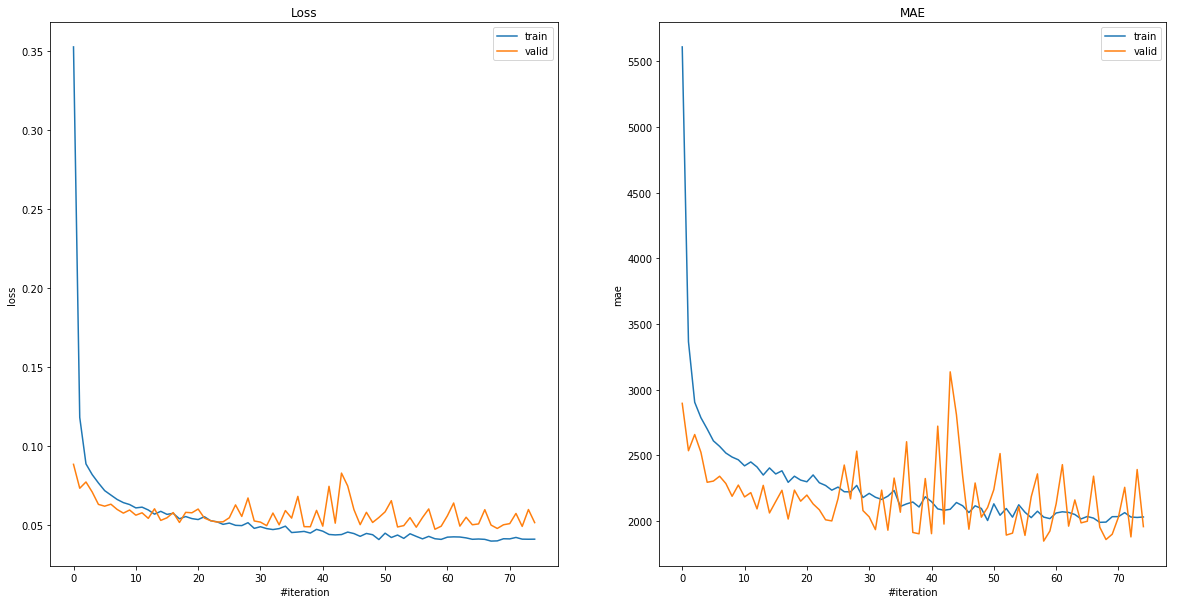

Final eval:



	Loss:	0.04738
	MAE:	1848.09105





In [64]:
plot_metrics({"Loss": {"train": train_losses[1:],
                       "valid": val_losses[1:]},
              "MAE": {"train": train_mae_list[1:],
                      "valid": val_mae_list[1:]}})
model.load_state_dict(best_model_dict)
evaluate(model, data_val, batch_size=batch_size, use_cuda=True)

## Parallel convolution encoders + dropout + batchnorm 

In [65]:
title_encoder = ParallelCnnEncoder(use_dropout=True, use_bn=True, dropout_p=0.2)

desc_encoder = ParallelCnnEncoder(use_dropout=True, use_bn=True, dropout_p=0.2)

model = FullNetwork(title_encoder, desc_encoder, use_bn=True, use_dropout=True, dropout_p=0.2)
opt = torch.optim.Adam(model.parameters(), lr=0.1)
num_epochs = 1000
max_len = 100
batch_size = 512
batches_per_epoch = None
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val, num_epochs,
                                                       batch_size, batches_per_epoch,
                                                       opt, use_cuda=True,
                                                       early_stopping_iters=15)

Training:



	Loss:	3.23491
	MAE:	72357.62778



Validation:



	Loss:	0.16356
	MAE:	3876.35411
0



Training:



	Loss:	0.33345
	MAE:	5420.83868



Validation:



	Loss:	0.10151
	MAE:	3105.15867
0



Training:



	Loss:	0.12230
	MAE:	3421.08793



Validation:



	Loss:	0.08517
	MAE:	2812.56070
0



Training:



	Loss:	0.09570
	MAE:	3018.98000



Validation:



	Loss:	0.07623
	MAE:	2584.19048
0



Training:



	Loss:	0.08878
	MAE:	2902.02509



Validation:



	Loss:	0.07143
	MAE:	2475.62761
0



Training:



	Loss:	0.08327
	MAE:	2807.73862



Validation:



	Loss:	0.06817
	MAE:	2405.91563
0



Training:



	Loss:	0.07819
	MAE:	2724.44832



Validation:



	Loss:	0.06830
	MAE:	2422.60218
1



Training:



	Loss:	0.07521
	MAE:	2673.13285



Validation:



	Loss:	0.06746
	MAE:	2445.68004
0



Training:



	Loss:	0.07187
	MAE:	2619.83618



Validation:



	Loss:	0.06335
	MAE:	2340.61933
0



Training:



	Loss:	0.07021
	MAE:	2597.43720



Validation:



	Loss:	0.06051
	MAE:	2236.39605
0



Training:



	Loss:	0.06668
	MAE:	2528.29186



Validation:



	Loss:	0.06000
	MAE:	2252.70572
0



Training:



	Loss:	0.06523
	MAE:	2504.57844



Validation:



	Loss:	0.05681
	MAE:	2159.28699
0



Training:



	Loss:	0.06488
	MAE:	2512.14068



Validation:



	Loss:	0.06916
	MAE:	2536.91892
1



Training:



	Loss:	0.06364
	MAE:	2489.19954



Validation:



	Loss:	0.05584
	MAE:	2134.39428
0



Training:



	Loss:	0.06063
	MAE:	2423.96168



Validation:



	Loss:	0.07621
	MAE:	2726.81067
1



Training:



	Loss:	0.06266
	MAE:	2479.86405



Validation:



	Loss:	0.07929
	MAE:	2800.09233
2



Training:



	Loss:	0.06067
	MAE:	2438.81237



Validation:



	Loss:	0.06683
	MAE:	2478.84960
3



Training:



	Loss:	0.06048
	MAE:	2439.95602



Validation:



	Loss:	0.06097
	MAE:	2247.61526
4



Training:



	Loss:	0.05824
	MAE:	2380.08295



Validation:



	Loss:	0.05487
	MAE:	2092.90090
0



Training:



	Loss:	0.05768
	MAE:	2380.59795



Validation:



	Loss:	0.05744
	MAE:	2184.40650
1



Training:



	Loss:	0.05694
	MAE:	2367.88507



Validation:



	Loss:	0.06103
	MAE:	2325.98193
2



Training:



	Loss:	0.05715
	MAE:	2378.24991



Validation:



	Loss:	0.05208
	MAE:	2039.89302
0



Training:



	Loss:	0.05615
	MAE:	2357.14568



Validation:



	Loss:	0.05179
	MAE:	2009.31187
0



Training:



	Loss:	0.05433
	MAE:	2313.73378



Validation:



	Loss:	0.05257
	MAE:	2045.75886
1



Training:



	Loss:	0.05430
	MAE:	2317.13157



Validation:



	Loss:	0.05780
	MAE:	2243.74613
2



Training:



	Loss:	0.05125
	MAE:	2239.24041



Validation:



	Loss:	0.06161
	MAE:	2387.72429
3



Training:



	Loss:	0.05410
	MAE:	2319.42826



Validation:



	Loss:	0.06319
	MAE:	2388.95245
4



Training:



	Loss:	0.05285
	MAE:	2288.49404



Validation:



	Loss:	0.09280
	MAE:	3111.80442
5



Training:



	Loss:	0.05258
	MAE:	2287.91184



Validation:



	Loss:	0.05132
	MAE:	1966.36435
0



Training:



	Loss:	0.05166
	MAE:	2267.03264



Validation:



	Loss:	0.05768
	MAE:	2253.87968
1



Training:



	Loss:	0.05049
	MAE:	2235.21691



Validation:



	Loss:	0.05165
	MAE:	2033.78388
2



Training:



	Loss:	0.04934
	MAE:	2210.51241



Validation:



	Loss:	0.05087
	MAE:	1966.93917
0



Training:



	Loss:	0.04902
	MAE:	2202.86292



Validation:



	Loss:	0.06037
	MAE:	2354.57888
1



Training:



	Loss:	0.04926
	MAE:	2212.92685



Validation:



	Loss:	0.05416
	MAE:	2098.51662
2



Training:



	Loss:	0.04932
	MAE:	2215.34746



Validation:



	Loss:	0.06427
	MAE:	2454.44069
3



Training:



	Loss:	0.04910
	MAE:	2212.40185



Validation:



	Loss:	0.06384
	MAE:	2435.21435
4



Training:



	Loss:	0.04894
	MAE:	2206.07994



Validation:



	Loss:	0.05365
	MAE:	2134.10366
5



Training:



	Loss:	0.04682
	MAE:	2148.55487



Validation:



	Loss:	0.05941
	MAE:	2339.26922
6



Training:



	Loss:	0.04685
	MAE:	2153.80904



Validation:



	Loss:	0.05224
	MAE:	1992.14798
7



Training:



	Loss:	0.04834
	MAE:	2196.45564



Validation:



	Loss:	0.05464
	MAE:	2085.69436
8



Training:



	Loss:	0.04672
	MAE:	2153.40381



Validation:



	Loss:	0.10105
	MAE:	3273.81703
9



Training:



	Loss:	0.04752
	MAE:	2177.76263



Validation:



	Loss:	0.05430
	MAE:	2047.78052
10



Training:



	Loss:	0.04609
	MAE:	2138.05171



Validation:



	Loss:	0.04955
	MAE:	1901.23163
0



Training:



	Loss:	0.04550
	MAE:	2127.67269



Validation:



	Loss:	0.04921
	MAE:	1910.35813
0



Training:



	Loss:	0.04637
	MAE:	2150.47901



Validation:



	Loss:	0.05065
	MAE:	1994.04506
1



Training:



	Loss:	0.04710
	MAE:	2174.21987



Validation:



	Loss:	0.08428
	MAE:	2942.90715
2



Training:



	Loss:	0.04456
	MAE:	2098.04341



Validation:



	Loss:	0.04970
	MAE:	1958.76149
3



Training:



	Loss:	0.04486
	MAE:	2114.70781



Validation:



	Loss:	0.05259
	MAE:	2081.69154
4



Training:



	Loss:	0.04928
	MAE:	2239.81207



Validation:



	Loss:	0.05033
	MAE:	1986.18033
5



Training:



	Loss:	0.04472
	MAE:	2108.71637



Validation:



	Loss:	0.06331
	MAE:	2433.45360
6



Training:



	Loss:	0.04552
	MAE:	2138.48292



Validation:



	Loss:	0.05758
	MAE:	2263.15072
7



Training:



	Loss:	0.04319
	MAE:	2066.87177



Validation:



	Loss:	0.05265
	MAE:	2082.69286
8



Training:



	Loss:	0.04409
	MAE:	2094.38579



Validation:



	Loss:	0.05774
	MAE:	2262.71326
9



Training:



	Loss:	0.04349
	MAE:	2080.21542



Validation:



	Loss:	0.05016
	MAE:	1932.39778
10



Training:



	Loss:	0.04368
	MAE:	2087.19954



Validation:



	Loss:	0.04955
	MAE:	1920.63882
11



Training:



	Loss:	0.04379
	MAE:	2090.52965



Validation:



	Loss:	0.05433
	MAE:	2056.49321
12



Training:



	Loss:	0.04295
	MAE:	2063.26710



Validation:



	Loss:	0.04931
	MAE:	1917.92914
13



Training:



	Loss:	0.04421
	MAE:	2106.06139



Validation:



	Loss:	0.09033
	MAE:	3082.05058
14



Training:



	Loss:	0.04635
	MAE:	2166.76460



Validation:



	Loss:	0.04899
	MAE:	1880.92045
0



Training:



	Loss:	0.04372
	MAE:	2089.43068



Validation:



	Loss:	0.04863
	MAE:	1889.74216
0



Training:



	Loss:	0.04138
	MAE:	2019.99166



Validation:



	Loss:	0.05649
	MAE:	2241.64323
1



Training:



	Loss:	0.04374
	MAE:	2095.93586



Validation:



	Loss:	0.06334
	MAE:	2391.59879
2



Training:



	Loss:	0.04314
	MAE:	2076.48877



Validation:



	Loss:	0.05008
	MAE:	1966.19324
3



Training:



	Loss:	0.04417
	MAE:	2110.27018



Validation:



	Loss:	0.04842
	MAE:	1887.69111
0



Training:



	Loss:	0.04138
	MAE:	2020.92380



Validation:



	Loss:	0.05089
	MAE:	1963.72759
1



Training:



	Loss:	0.04250
	MAE:	2059.19683



Validation:



	Loss:	0.07853
	MAE:	2833.33096
2



Training:



	Loss:	0.04269
	MAE:	2063.83873



Validation:



	Loss:	0.06977
	MAE:	2613.63357
3



Training:



	Loss:	0.04331
	MAE:	2081.95280



Validation:



	Loss:	0.04895
	MAE:	1926.86188
4



Training:



	Loss:	0.04254
	MAE:	2064.62993



Validation:



	Loss:	0.04994
	MAE:	1932.97919
5



Training:



	Loss:	0.04145
	MAE:	2029.18700



Validation:



	Loss:	0.04977
	MAE:	1971.03775
6



Training:



	Loss:	0.04133
	MAE:	2026.12349



Validation:



	Loss:	0.05194
	MAE:	2034.38728
7



Training:



	Loss:	0.04339
	MAE:	2086.39764



Validation:



	Loss:	0.05648
	MAE:	2202.31597
8



Training:



	Loss:	0.04217
	MAE:	2056.71236



Validation:



	Loss:	0.07565
	MAE:	2772.35996
9



Training:



	Loss:	0.04250
	MAE:	2062.50535



Validation:



	Loss:	0.04929
	MAE:	1907.00403
10



Training:



	Loss:	0.04200
	MAE:	2050.65409



Validation:



	Loss:	0.04820
	MAE:	1855.73350
0



Training:



	Loss:	0.04030
	MAE:	1996.58224



Validation:



	Loss:	0.04864
	MAE:	1859.30664
1



Training:



	Loss:	0.04298
	MAE:	2082.83175



Validation:



	Loss:	0.04872
	MAE:	1883.72880
2



Training:



	Loss:	0.04121
	MAE:	2029.52066



Validation:



	Loss:	0.04846
	MAE:	1868.90897
3



Training:



	Loss:	0.04253
	MAE:	2068.33160



Validation:



	Loss:	0.05420
	MAE:	2151.09027
4



Training:



	Loss:	0.04120
	MAE:	2025.70747



Validation:



	Loss:	0.04993
	MAE:	1945.70721
5



Training:



	Loss:	0.04204
	MAE:	2052.14799



Validation:



	Loss:	0.04880
	MAE:	1917.92945
6



Training:



	Loss:	0.04093
	MAE:	2019.58339



Validation:



	Loss:	0.04862
	MAE:	1890.53139
7



Training:



	Loss:	0.04275
	MAE:	2078.37565



Validation:



	Loss:	0.06301
	MAE:	2433.21649
8



Training:



	Loss:	0.03995
	MAE:	1989.18737



Validation:



	Loss:	0.05397
	MAE:	2148.93140
9



Training:



	Loss:	0.04183
	MAE:	2053.56605



Validation:



	Loss:	0.04909
	MAE:	1926.21766
10



Training:



	Loss:	0.04126
	MAE:	2032.29633



Validation:



	Loss:	0.04888
	MAE:	1899.02702
11



Training:



	Loss:	0.04129
	MAE:	2029.94829



Validation:



	Loss:	0.06009
	MAE:	2346.82229
12



Training:



	Loss:	0.04079
	MAE:	2019.85549



Validation:



	Loss:	0.04765
	MAE:	1855.85923
0



Training:



	Loss:	0.04199
	MAE:	2054.51627



Validation:



	Loss:	0.05253
	MAE:	2083.69379
1



Training:



	Loss:	0.04160
	MAE:	2047.71256



Validation:



	Loss:	0.08058
	MAE:	2873.40275
2



Training:



	Loss:	0.04119
	MAE:	2026.39589



Validation:



	Loss:	0.05747
	MAE:	2270.06835
3



Training:



	Loss:	0.04109
	MAE:	2027.77659



Validation:



	Loss:	0.05453
	MAE:	2147.05454
4



Training:



	Loss:	0.04084
	MAE:	2020.33200



Validation:



	Loss:	0.05242
	MAE:	2001.85883
5



Training:



	Loss:	0.04083
	MAE:	2021.68217



Validation:



	Loss:	0.04856
	MAE:	1904.49207
6



Training:



	Loss:	0.03991
	MAE:	1991.75008



Validation:



	Loss:	0.05210
	MAE:	2081.87627
7



Training:



	Loss:	0.04083
	MAE:	2021.64704



Validation:



	Loss:	0.04730
	MAE:	1830.99512
0



Training:



	Loss:	0.04296
	MAE:	2084.55552



Validation:



	Loss:	0.04709
	MAE:	1827.59605
0



Training:



	Loss:	0.03883
	MAE:	1955.88692



Validation:



	Loss:	0.05719
	MAE:	2239.48676
1



Training:



	Loss:	0.03930
	MAE:	1972.75072



Validation:



	Loss:	0.06330
	MAE:	2438.42461
2



Training:



	Loss:	0.04035
	MAE:	2008.38587



Validation:



	Loss:	0.05894
	MAE:	2315.47830
3



Training:



	Loss:	0.04065
	MAE:	2015.49930



Validation:



	Loss:	0.04824
	MAE:	1845.65896
4



Training:



	Loss:	0.04052
	MAE:	2019.33276



Validation:



	Loss:	0.05360
	MAE:	2122.09034
5



Training:



	Loss:	0.04036
	MAE:	2012.18339



Validation:



	Loss:	0.04940
	MAE:	1912.00527
6



Training:



	Loss:	0.04183
	MAE:	2058.64014



Validation:



	Loss:	0.05839
	MAE:	2300.43641
7



Training:



	Loss:	0.03955
	MAE:	1987.47978



Validation:



	Loss:	0.04860
	MAE:	1864.25276
8



Training:



	Loss:	0.03927
	MAE:	1976.26519



Validation:



	Loss:	0.05643
	MAE:	2144.62828
9



Training:



	Loss:	0.03933
	MAE:	1979.63451



Validation:



	Loss:	0.05340
	MAE:	2115.64668
10



Training:



	Loss:	0.04119
	MAE:	2036.27831



Validation:



	Loss:	0.07090
	MAE:	2633.06730
11



Training:



	Loss:	0.03889
	MAE:	1960.09027



Validation:



	Loss:	0.05012
	MAE:	1972.40298
12



Training:



	Loss:	0.03962
	MAE:	1986.63691



Validation:



	Loss:	0.04790
	MAE:	1852.98532
13



Training:



	Loss:	0.03991
	MAE:	1996.63654



Validation:



	Loss:	0.04694
	MAE:	1825.15776
0



Training:



	Loss:	0.03918
	MAE:	1973.32096



Validation:



	Loss:	0.05776
	MAE:	2269.02828
1



Training:



	Loss:	0.04013
	MAE:	2006.17160



Validation:



	Loss:	0.05552
	MAE:	2188.02082
2



Training:



	Loss:	0.03987
	MAE:	1996.22694



Validation:



	Loss:	0.05209
	MAE:	2045.81604
3



Training:



	Loss:	0.04113
	MAE:	2041.49243



Validation:



	Loss:	0.05305
	MAE:	2032.70149
4



Training:



	Loss:	0.03924
	MAE:	1977.75620



Validation:



	Loss:	0.05048
	MAE:	1890.98731
5



Training:



	Loss:	0.03879
	MAE:	1958.50582



Validation:



	Loss:	0.04905
	MAE:	1870.07979
6



Training:



	Loss:	0.03861
	MAE:	1963.93363



Validation:



	Loss:	0.05089
	MAE:	2014.07397
7



Training:



	Loss:	0.03937
	MAE:	1983.72071



Validation:



	Loss:	0.05618
	MAE:	2213.36257
8



Training:



	Loss:	0.04053
	MAE:	2018.45945



Validation:



	Loss:	0.07583
	MAE:	2766.59206
9



Training:



	Loss:	0.03932
	MAE:	1982.01384



Validation:



	Loss:	0.07140
	MAE:	2666.88071
10



Training:



	Loss:	0.03928
	MAE:	1978.49752



Validation:



	Loss:	0.06567
	MAE:	2507.10337
11



Training:



	Loss:	0.04066
	MAE:	2022.68613



Validation:



	Loss:	0.05225
	MAE:	2016.51378
12



Training:



	Loss:	0.03971
	MAE:	1990.22607



Validation:



	Loss:	0.05069
	MAE:	1934.97501
13



Training:



	Loss:	0.03795
	MAE:	1934.43647



Validation:



	Loss:	0.04936
	MAE:	1944.99356
14



Training:



	Loss:	0.03872
	MAE:	1961.91749



Validation:



	Loss:	0.04989
	MAE:	1972.34486
15



Training:



	Loss:	0.03862
	MAE:	1958.07242



Validation:



	Loss:	0.06680
	MAE:	2555.24666
16





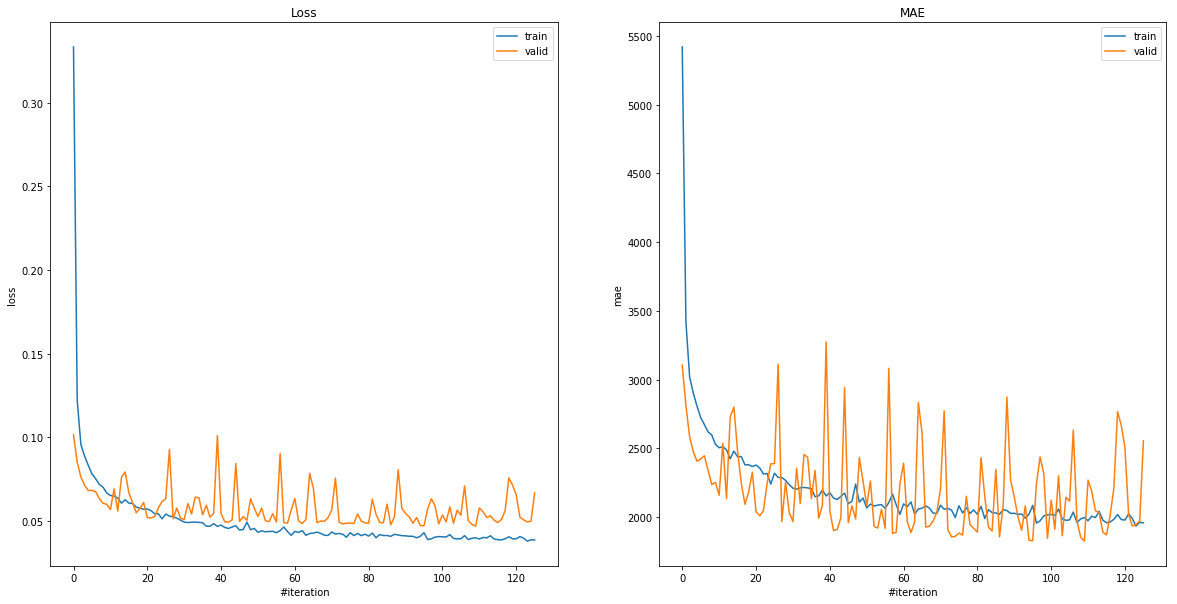

Final eval:



	Loss:	0.04694
	MAE:	1825.15776





In [68]:
plot_metrics({"Loss": {"train": train_losses[1:],
                       "valid": val_losses[1:]},
              "MAE": {"train": train_mae_list[1:],
                      "valid": val_mae_list[1:]}})
model.load_state_dict(best_model_dict)
evaluate(model, data_val, batch_size=batch_size, use_cuda=True)

## BiLSTM encoders + batchnorm + dropout

In [33]:
title_encoder = LSTMEncoder(use_dropout=True, use_bn=True, num_layers=2,
                            hidden_size=128,
                            dropout_p=0.2, bidirectional=True)

desc_encoder = LSTMEncoder(use_dropout=True, use_bn=True, num_layers=2,
                           hidden_size=128,
                           dropout_p=0.2, bidirectional=True)

model = FullNetwork(title_encoder, desc_encoder, use_bn=True, use_dropout=True, dropout_p=0.2)
model = nn.DataParallel(model.cuda())
opt = torch.optim.Adam(model.parameters(), lr=0.1)
num_epochs = 1000
batch_size = 100
batches_per_epoch = None
(train_losses, val_losses,
 train_mae_list, val_mae_list, best_model_dict) = train(model, data_train, data_val, num_epochs,
                                                       batch_size, batches_per_epoch,
                                                       opt, use_cuda=True,
                                                       early_stopping_iters=15)

Training:



	Loss:	0.83629
	MAE:	61900.70300



Validation:



	Loss:	0.16376
	MAE:	3964.22013
0



Training:



	Loss:	0.16258
	MAE:	3924.30581



Validation:



	Loss:	0.14862
	MAE:	3752.03724
0



Training:



	Loss:	0.16423
	MAE:	3947.23513



Validation:



	Loss:	0.18268
	MAE:	4206.12050
1



Training:



	Loss:	0.16251
	MAE:	3920.44446



Validation:



	Loss:	0.15329
	MAE:	3738.36948
2



Training:



	Loss:	0.15880
	MAE:	3863.97146



Validation:



	Loss:	0.14666
	MAE:	3685.49299
0



Training:



	Loss:	0.15831
	MAE:	3861.87606



Validation:



	Loss:	0.14672
	MAE:	3741.46927
1



Training:



	Loss:	0.15622
	MAE:	3830.77722



Validation:



	Loss:	0.14042
	MAE:	3556.97226
0



Training:



	Loss:	0.15568
	MAE:	3822.10828



Validation:



	Loss:	0.14830
	MAE:	3782.07927
1



Training:



	Loss:	0.15305
	MAE:	3779.79341



Validation:



	Loss:	0.13540
	MAE:	3503.78076
0



Training:



	Loss:	0.15249
	MAE:	3781.26137



Validation:



	Loss:	0.13890
	MAE:	3583.90720
1



Training:



	Loss:	0.15022
	MAE:	3748.59942



Validation:



	Loss:	0.13928
	MAE:	3565.54600
2



Training:



	Loss:	0.14944
	MAE:	3738.84340



Validation:



	Loss:	0.13299
	MAE:	3532.80596
0



Training:



	Loss:	0.14842
	MAE:	3724.86375



Validation:



	Loss:	0.15691
	MAE:	3905.19167
1



Training:



	Loss:	0.14799
	MAE:	3718.01915



Validation:



	Loss:	0.14732
	MAE:	3767.41822
2



Training:



	Loss:	0.14750
	MAE:	3721.32365



Validation:



	Loss:	0.14220
	MAE:	3600.82664
3



Training:



	Loss:	0.14617
	MAE:	3696.00768



Validation:



	Loss:	0.13670
	MAE:	3524.68397
4



Training:



	Loss:	0.14563
	MAE:	3694.16542



Validation:



	Loss:	0.14539
	MAE:	3609.07308
5



Training:



	Loss:	0.14390
	MAE:	3664.98826



Validation:



	Loss:	0.13180
	MAE:	3476.66409
0



Training:



	Loss:	0.14442
	MAE:	3672.56292



Validation:



	Loss:	0.13538
	MAE:	3580.39200
1



Training:



	Loss:	0.14368
	MAE:	3664.32571



Validation:



	Loss:	0.15272
	MAE:	3845.40204
2



Training:



	Loss:	0.14261
	MAE:	3649.10831



Validation:



	Loss:	0.13127
	MAE:	3446.13960
0



Training:


/home/penguin138/.virtualenvs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().



	Loss:	0.14188
	MAE:	3636.32191



Validation:



	Loss:	0.13390
	MAE:	3479.03676
1



Training:



	Loss:	0.14167
	MAE:	3638.87680



Validation:



	Loss:	0.13651
	MAE:	3528.90192
2



Training:



	Loss:	0.14190
	MAE:	3642.34046



Validation:



	Loss:	0.13782
	MAE:	3583.79460
3



Training:



	Loss:	0.14111
	MAE:	3623.92707



Validation:



	Loss:	0.14559
	MAE:	3646.48312
4



Training:



	Loss:	0.14042
	MAE:	3620.14929



Validation:



	Loss:	0.13663
	MAE:	3592.32656
5



Training:



	Loss:	0.14064
	MAE:	3621.75657



Validation:



	Loss:	0.13417
	MAE:	3502.64407
6



Training:



	Loss:	0.13982
	MAE:	3613.25842



Validation:



	Loss:	0.15391
	MAE:	3848.56466
7



Training:



	Loss:	0.14022
	MAE:	3620.04121



Validation:



	Loss:	0.13348
	MAE:	3520.08276
8



Training:



	Loss:	0.13988
	MAE:	3611.79640



Validation:



	Loss:	0.13307
	MAE:	3496.89738
9



Training:



	Loss:	0.13865
	MAE:	3591.59064



Validation:



	Loss:	0.14380
	MAE:	3695.61283
10



Training:



	Loss:	0.13886
	MAE:	3601.23639



Validation:



	Loss:	0.13728
	MAE:	3602.46073
11



Training:



	Loss:	0.13817
	MAE:	3586.83084



Validation:



	Loss:	0.13755
	MAE:	3541.41203
12



Training:



	Loss:	0.13839
	MAE:	3590.65740



Validation:



	Loss:	0.13464
	MAE:	3518.24801
13



Training:



	Loss:	0.13688
	MAE:	3570.52033



Validation:



	Loss:	0.13605
	MAE:	3553.33377
14



Training:



	Loss:	0.13748
	MAE:	3571.89125



Validation:



	Loss:	0.13102
	MAE:	3468.87753
0



Training:



	Loss:	0.13760
	MAE:	3575.07373



Validation:



	Loss:	0.13216
	MAE:	3452.28734
1



Training:



	Loss:	0.13692
	MAE:	3567.30973



Validation:



	Loss:	0.14458
	MAE:	3721.14008
2



Training:



	Loss:	0.13790
	MAE:	3584.02406



Validation:



	Loss:	0.13227
	MAE:	3489.15161
3



Training:



	Loss:	0.13607
	MAE:	3554.14159



Validation:



	Loss:	0.13687
	MAE:	3521.08509
4



Training:



	Loss:	0.13761
	MAE:	3573.56902



Validation:



	Loss:	0.13181
	MAE:	3479.13540
5



Training:



	Loss:	0.13563
	MAE:	3548.72407



Validation:



	Loss:	0.13106
	MAE:	3430.20638
6



Training:



	Loss:	0.13604
	MAE:	3553.33391



Validation:



	Loss:	0.13174
	MAE:	3445.73551
7



Training:



	Loss:	0.13604
	MAE:	3554.82280



Validation:



	Loss:	0.13604
	MAE:	3492.11185
8



Training:



	Loss:	0.13545
	MAE:	3544.89236



Validation:



	Loss:	0.14323
	MAE:	3661.58647
9



Training:



	Loss:	0.13573
	MAE:	3550.78840



Validation:



	Loss:	0.13207
	MAE:	3461.39831
10



Training:



	Loss:	0.13565
	MAE:	3549.39292



Validation:



	Loss:	0.13922
	MAE:	3574.43896
11



Training:



	Loss:	0.13398
	MAE:	3525.50851



Validation:



	Loss:	0.14227
	MAE:	3582.88019
12



Training:



	Loss:	0.13451
	MAE:	3531.63303



Validation:



	Loss:	0.13632
	MAE:	3581.53001
13



Training:



	Loss:	0.13473
	MAE:	3533.44821



Validation:



	Loss:	0.13407
	MAE:	3524.38135
14



Training:



	Loss:	0.13548
	MAE:	3548.18892



Validation:



	Loss:	0.15142
	MAE:	3821.19908
15



Training:



	Loss:	0.13433
	MAE:	3531.00866



Validation:



	Loss:	0.13624
	MAE:	3522.53621
16





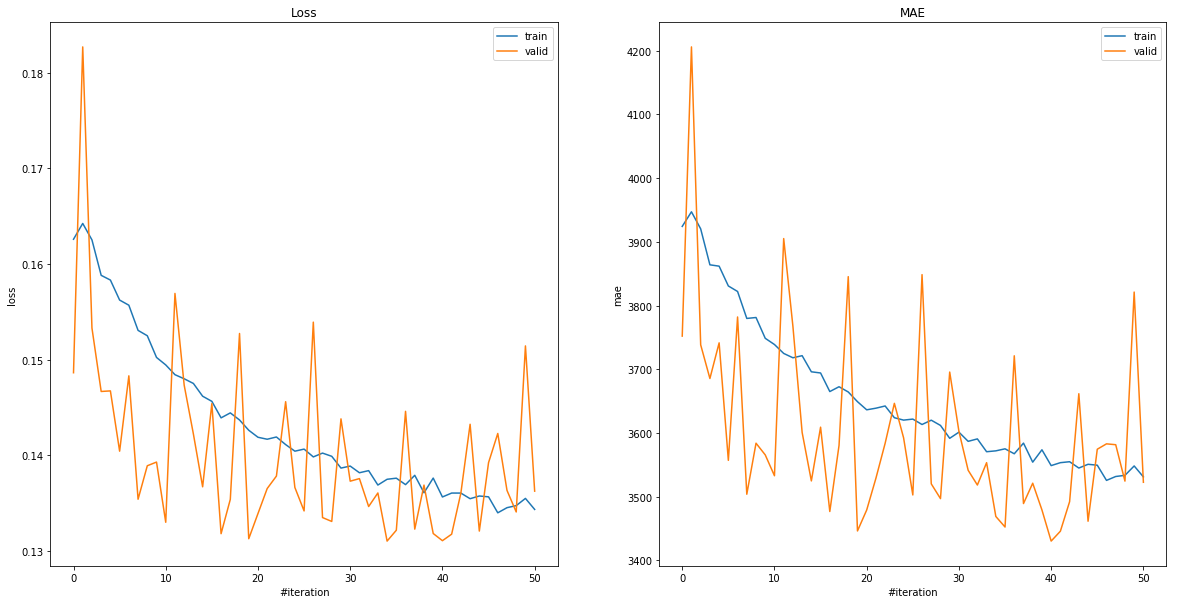

Final eval:



	Loss:	0.13102
	MAE:	3468.87753





In [34]:
plot_metrics({"Loss": {"train": train_losses[1:],
                       "valid": val_losses[1:]},
              "MAE": {"train": train_mae_list[1:],
                      "valid": val_mae_list[1:]}})
model.load_state_dict(best_model_dict)
evaluate(model, data_val, batch_size=batch_size, use_cuda=True)

### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

After training baseline model first thing that I did was improve functions, that were used for training.

It turned out that function that was responsible for iterating over training set had a flaw. While creating a batch it actually sampled with replacement from it. Therefore, model didn't observe all elements from training set, and all metrics computed on validation set were not consistent from one evaluation to another. This flaw was corrected by setting ```replace = False``` in ```generate_batch``` call.

The next thing that I did was early stopping, also I maintained best-on-validation state_dict for each model and plotted all metrics on train and validation.

Then I tried all sorts of convolutional architectures (all of them using early stopping) and also LSTM models (with early stopping). Learning curves for them you can find above.

Results summary:

|Model description                                 | MAE    |
|:-------------------------------------------------|:------:|
|baseline                                          |2609    |
|baseline with early stopping                      | 2124.3 |
|baseline model with batchnorm                     |1971.9  |
|big convolutional architecture with batchnorm     |1968.7  |
|small convolutional architecture with batchnorm   |2050    |
|baseline model with batchnorm and dropout         |**1848**|
|assymetric architecture with batchnorm and dropout|1970    | 
|parallel convolutions with batchnorm and dropout  |**1825**|
|lstm architecture with batchnorm                  | 3468.8 |

All in all, recurrent architectures didn't perform well and for convolutional architectures dropout and parallel convolutions turned out to be the most helpful tricks.